In [4]:
import json
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
import csv
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [5]:
COLORS = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
METRIC_LIMIT = {'R1': 0.37, 'R2': 0.06, 'RL': 0.29, 'RSU': 0.11, 'litepyramid': 0.5}
WORD_COUNT_LIMITS = [float("-inf"), 100, 150, 250, 350]

In [6]:
def loadResultsFile(resultsFilepath):
    with open(resultsFilepath, 'r') as fIn:
        data = json.load(fIn)
    return data

In [39]:
def getXYvalues(allResults, metrics):
    xAll = {} # topic -> systemName -> [x values]
    yAllRecall = {metric: {} for metric in metrics} # metric -> topic -> systemName -> [y values]
    yAllF1 = {metric: {} for metric in metrics} # metric -> topic -> systemName -> [y values]
    for systemName, systemResults in allResults.items():
        for topic in systemResults:
            for sessionInfo in systemResults[topic]:
                xSystem = []
                ySystemRecall = {metric: [] for metric in metrics}
                ySystemF1 = {metric: [] for metric in metrics}
                for resultsAtLen in sessionInfo['scores']:
                    xSystem.append(resultsAtLen['summary_len'])
                    for metric in metrics:
                        if metric in resultsAtLen['results']:
                            ySystemRecall[metric].append(resultsAtLen['results'][metric]['recall'])
                            if 'f1' in resultsAtLen['results'][metric]:
                                ySystemF1[metric].append(resultsAtLen['results'][metric]['f1'])
                            else:
                                ySystemF1[metric].append(-1.0)
                        else:
                            ySystemRecall[metric].append(-1.0)
                            ySystemF1[metric].append(-1.0)

                sessionName = '{}_{}'.format(systemName, sessionInfo['id'])
                xAll.setdefault(topic, {})[sessionName] = xSystem
                for metric in metrics:
                    yAllRecall[metric].setdefault(topic, {})[sessionName] = ySystemRecall[metric]
                    yAllF1[metric].setdefault(topic, {})[sessionName] = ySystemF1[metric]
    
    return xAll, yAllRecall, yAllF1

def getIntersectingXYvalues(xAll, yAll):
    # returns new xAll and yAll values, looking only at the intersecting ranges of the systems
    
    # get the X value that is the lowest value of the maximum X values over all systems (for each of the topics)
    # get the X value that is the highest value of the minimum X values over all systems (for each of the topics)
    minmaxX = {topic:9999999 for topic in xAll} # topic -> minMaxX
    maxminX = {topic:-1 for topic in xAll} # topic -> maxMinX
    for topic in xAll:
        for systemName in xAll[topic]:
            maxXOfSystem = xAll[topic][systemName][-1] # the maximum X value of the system
            minXOfSystem = xAll[topic][systemName][0] # the minimum X value of the system
            if maxXOfSystem < minmaxX[topic]:
                minmaxX[topic] = maxXOfSystem
            if minXOfSystem > maxminX[topic]:
                maxminX[topic] = minXOfSystem
                
    # create the new X and Y value lists only looking from the maxminX upto the minmaxX:
    xAllNew = {}
    yAllNew = {}
    for topic in xAll:
        xAllNew[topic] = {}
        for systemName in xAll[topic]:
            xAllNew[topic][systemName] = []
            for xIdx, x in enumerate(xAll[topic][systemName]):
                
                # if the current x value is the one right before the minmax, then get the interpolated y value:
                if x < maxminX[topic] and xAll[topic][systemName][xIdx+1] > maxminX[topic]:
                    xAllNew[topic][systemName].append(maxminX[topic]) # the X is the maxmin (start of intersecting region)
                    for metric in yAll:
                        newYval = getInterpolatedYval(xAll[topic][systemName], yAll[metric][topic][systemName], xIdx, maxminX[topic])
                        yAllNew.setdefault(metric, {}).setdefault(topic, {}).setdefault(systemName, []).append(newYval)
                        
                # if the current x value is the one right after the maxmin, then get the interpolated y value:
                elif x > minmaxX[topic] and xAll[topic][systemName][xIdx-1] < minmaxX[topic]:
                    xAllNew[topic][systemName].append(minmaxX[topic]) # the X is the minmax (end of intersecting region)
                    for metric in yAll:
                        newYval = getInterpolatedYval(xAll[topic][systemName], yAll[metric][topic][systemName], xIdx-1, minmaxX[topic])
                        yAllNew.setdefault(metric, {}).setdefault(topic, {}).setdefault(systemName, []).append(newYval)
                        
                # if the current x value is the exact maxmin or minmax or between the two, put the original values as is:
                elif x >= maxminX[topic] and x <= minmaxX[topic]:
                    xAllNew[topic][systemName].append(x)
                    for metric in yAll:
                        yAllNew.setdefault(metric, {}).setdefault(topic, {}).setdefault(systemName, []).append(
                            yAll[metric][topic][systemName][xIdx])
                
    return xAllNew, yAllNew

def getInterpolatedYval(xList, yList, idxStart, neededXval):
    # gets the y value at the neededXval, between idxStart and idxStart+1:
    return np.interp(neededXval, xList[idxStart:idxStart+2], yList[idxStart:idxStart+2])

def getInterpolatedXval(xList, yList, idxStart, neededYval):
    # gets the x value at the neededYval, between idxStart and idxStart+1
    # this is done by switching the X and Y axis, and setting the neededYval as the neededXval
    return getInterpolatedYval(yList, xList, idxStart, neededYval)

def getAUCvalues(xAll, yAll, xMin=float('inf'), xMax=float('-inf')):
    aucAll = {} # metric -> topic -> systemName -> {'auc':aucVal, 'xRange':xRange}
    for metric in yAll:
        for topic in yAll[metric]:
            for systemName in yAll[metric][topic]:
                xList, yList = getXYvaluesInRange(xAll[topic][systemName], yAll[metric][topic][systemName], xMin, xMax)
                aucVal = auc(xList, yList)
                xRange = xList[-1] - xList[0]
                xStart = xList[0]
                aucAll.setdefault(metric, {}).setdefault(topic, {})[systemName] = {'auc':aucVal, 'xRange':xRange, 'xStart': xStart}
    return aucAll

def getXYvaluesInRange(xList, yList, xMin, xMax):
    # returns the xList and yList in the x range specified
    # assuming xList and yList are corresponding
    
    if xMin > xMax:
        return xList, yList
    
    inf = float('inf')
    negInf = float('-inf')
    # don't let the xMin and xMax be out of range of the xList
    if xMin < xList[0]:
        xMin = inf
    if xMax > xList[-1]:
        xMax = negInf
    # nothing to change:
    if xMin == inf and xMax == negInf:
        return xList, yList
    
    # if given -inf or inf, then set it as the min or max values of the xList:
    if xMin == inf:
        xMin = xList[0]
    if xMax == negInf:
        xMax = xList[-1]
    
    # generate the new lists, and take care to interpolate the min and max values if necessary:
    newXList = []
    newYList = []
    for xIdx, (x, y) in enumerate(zip(xList, yList)):
        if x < xMin and xList[xIdx+1] > xMin:
            newXList.append(xMin)
            newYList.append(getInterpolatedYval(xList, yList, xIdx, xMin))
            if xMin == xMax:
                break
        elif (x == xMin) or (x > xMin and x < xMax) or (x == xMax):
            newXList.append(x)
            newYList.append(y)
        elif x > xMax and xList[xIdx-1] < xMax:
            newXList.append(xMax)
            newYList.append(getInterpolatedYval(xList, yList, xIdx-1, xMax))
            
    return newXList, newYList
    

def getXatYlimits(xAll, yAll, metricLimits):
    # gets the X values (word counts) at which the Y limits (scores) are reached
    xAllAtMetricLimits = {} # metric -> topic -> sysName -> {'xVal', 'xRelative'}
    for metric in yAll:
        curMetricLimit = metricLimits[metric]
        for topic in yAll[metric]:
            for sysName in yAll[metric][topic]:
                xValAtLimit = None
                xValRelativeInRange = None
                maxYidx = len(yAll[metric][topic][sysName]) - 1
                # find the X value for the Y value needed:
                for yValIdx, yVal in enumerate(yAll[metric][topic][sysName]):
                    # the current Y value is the limit, so just take the X value:
                    if yVal == curMetricLimit:
                        xValAtLimit = xAll[topic][sysName][yValIdx]
                        break
                    # the current Y value is smaller than the limit, and the next Y value is large, so interpolate:
                    elif yValIdx < maxYidx and yVal < curMetricLimit and yAll[metric][topic][sysName][yValIdx+1] > curMetricLimit:
                        xValAtLimit = getInterpolatedXval(xAll[topic][sysName], yAll[metric][topic][sysName], yValIdx, curMetricLimit)
                        break
                
                # if the X value was found, find the relative placement in the X range:
                if xValAtLimit != None:
                    xValRelativeInRange = (xValAtLimit - xAll[topic][sysName][0]) / (xAll[topic][sysName][-1] - xAll[topic][sysName][0])
                xAllAtMetricLimits.setdefault(metric, {}).setdefault(topic, {})[sysName] = {'xVal':xValAtLimit, 'xRelative':xValRelativeInRange}
    
    return xAllAtMetricLimits

def getYatXlimits(xAll, yAll, xLimit):
    # gets the Y values (scores) at which the X limit (word count) is reached
    yAllAtWordLimits = {} # metric -> topic -> sysName -> <yVal>
    for metric in yAll:
        for topic in yAll[metric]:
            for sysName in yAll[metric][topic]:
                # if neg infinity is requested, return the y value at the first x index
                if xLimit == float("-inf"):
                    yValAtLimit = yAll[metric][topic][sysName][0]
                
                else:
                    yValAtLimit = None
                    maxXidx = len(xAll[topic][sysName]) - 1
                    # find the Y value for the X value needed:
                    for xValIdx, xVal in enumerate(xAll[topic][sysName]):
                        # the current X value is the limit, so just take the Y value:
                        if xVal == xLimit:
                            yValAtLimit = yAll[metric][topic][sysName][xValIdx]
                            break
                        # the current X value is smaller than the limit, and the next X value is large, so interpolate:
                        elif xValIdx < maxXidx and xVal < xLimit and xAll[topic][sysName][xValIdx+1] > xLimit:
                            yValAtLimit = getInterpolatedYval(xAll[topic][sysName], yAll[metric][topic][sysName], xValIdx, xLimit)
                            break

                
                yAllAtWordLimits.setdefault(metric, {}).setdefault(topic, {})[sysName] = yValAtLimit

    return yAllAtWordLimits

def outputGraphs(allResults, metricLimits, wordCountLimits, outputFolder, xMinAucComputation=float('inf'), xMaxAucComputation=float('-inf')):
    metrics = list(metricLimits.keys())
    # X axis is the word count, and Y axis is the ROUGE score
    # get the X,Y values from the results json (yAll is the ROUGE recall scores which are the ones to use mostly):
    xAll, yAll, yAllF1 = getXYvalues(allResults, metrics)
    # get the X,Y values that the different systems intersect on for all metrics/topics:
    xAllIntersecting, yAllIntersecting = getIntersectingXYvalues(xAll, yAll)
    # get the AUCs of the intersecting regions for all metrics/topics/systems
    aucAllIntersecting = getAUCvalues(xAllIntersecting, yAllIntersecting, xMin=xMinAucComputation, xMax=xMaxAucComputation)
    # get the X values (word counts) at which the Y limits (ROUGE scores) are reached for all metrics/topics/systems:
    #xAllAtMetricLimits = getXatYlimits(xAllIntersecting, yAllIntersecting, metricLimits)
    xAllAtMetricLimits = getXatYlimits(xAll, yAllF1, metricLimits)
    # get the Y values (ROUGE/LitePyr scores) at which the X limit (word count) is reached for all metrics/topics/systems:
    yAllAtWordLimits = {wordCountLimit: getYatXlimits(xAll, yAllF1, wordCountLimit) for wordCountLimit in wordCountLimits}
    # for the lite-pyarmid scores ar the wordCountLimit, we will use the recall score instead of F1:
    yAllAtWordLimitsRecall = {wordCountLimit: getYatXlimits(xAll, yAll, wordCountLimit) for wordCountLimit in wordCountLimits}
    for wordCountLimit in wordCountLimits:
        for topic in yAllAtWordLimits[wordCountLimit]['litepyramid']:
            for sysName in yAllAtWordLimits[wordCountLimit]['litepyramid'][topic]:
                yAllAtWordLimits[wordCountLimit]['litepyramid'][topic][sysName] = yAllAtWordLimitsRecall[wordCountLimit]['litepyramid'][topic][sysName]
    
    systemColors = {} # systemName -> matplotlib color from COLORS
    
    
    Curves_XY = {}
    Curves_XY_intersecting = {}
    
    # A per-metric plot for each topic separately:
    for topic in xAll:
        # subplot for each ROUGE metric:
        fig, axPlotSet = plt.subplots(len(metrics), 1, sharex=True, figsize=(15, 15))
        # put the title over the top plot:
        axPlotSet[0].set(title='Incremental Gain per Operation')
        # put the X-axis label beneath the bottom plot:
        axPlotSet[-1].set(xlabel='Word Count')
        
        for metricIdx, metric in enumerate(metrics):
            # put the current plot's Y-axis label (the ROUGE metric):
            axPlotSet[metricIdx].set(ylabel='{} Score'.format(metric))
            # plot each system's curve for the current metric:
            for systemIdx, systemName in enumerate(xAll[topic]):
                X = xAll[topic][systemName]
                Y = yAll[metric][topic][systemName]
                Curves_XY.setdefault(metric, {}).setdefault(topic, {})[systemName] = [(x, y) for x, y in zip(X, Y)]
                X_intersecting = xAllIntersecting[topic][systemName]
                Y_intersecting = yAllIntersecting[metric][topic][systemName]
                Curves_XY_intersecting.setdefault(metric, {}).setdefault(topic, {})[systemName] = [(x, y) for x, y in zip(X_intersecting, Y_intersecting)]
                
                if systemName not in systemColors:
                    systemColors[systemName] = COLORS[systemIdx%len(COLORS)]
                
                # plot curve:
                axPlotSet[metricIdx].plot(X, Y, linestyle='-', color=systemColors[systemName], marker='x', label=systemName)
                
                # write the Y values next to the points:
                #for x, y in zip(X, Y):
                #    axPlotSet[metricIdx].annotate(str(y), xy=(x, y), xytext=(-10, 10), textcoords='offset points')
                
                # write the AUC values of the intersecting regions:
                #axPlotSet[metricIdx].text(np.mean(X_intersecting), np.mean(Y_intersecting) / 2, 'AUC: {:.2f}'.format(aucAllIntersecting[metric][topic][systemName]), color=systemColors[systemName])
                axPlotSet[metricIdx].text(X_intersecting[0], Y_intersecting[-1], 'AUC: {:.2f}'.format(aucAllIntersecting[metric][topic][systemName]['auc']), color=systemColors[systemName])
                ## fill the area under the curve in the intersecting regions:
                #axPlotSet[metricIdx].fill_between(X_intersecting, 0, Y_intersecting, facecolor=systemColors[systemName], alpha=0.3)
                # put a marker at the Y-limit:
                if xAllAtMetricLimits[metric][topic][systemName]['xVal'] != None:
                    axPlotSet[metricIdx].plot([xAllAtMetricLimits[metric][topic][systemName]['xVal']], [metricLimits[metric]], marker='X', color=systemColors[systemName])
                    axPlotSet[metricIdx].vlines(x=xAllAtMetricLimits[metric][topic][systemName]['xVal'], ymin=0, ymax=metricLimits[metric], linestyle='--', color=systemColors[systemName])
            
            # vertical lines at start and end of intersection:
            axPlotSet[metricIdx].axvline(x=X_intersecting[0], ymin=0, ymax=1, linestyle='--')
            axPlotSet[metricIdx].axvline(x=X_intersecting[-1], ymin=0, ymax=1, linestyle='--')
            # put a horizontal line at the Y limit:
            axPlotSet[metricIdx].hlines([metricLimits[metric]], 0, X_intersecting[-1], linestyles='--')
            
            # show the legend only on the litepyramid graph (which is unused) so that the rest of the graphs are visible
            if metric == 'litepyramid':
                axPlotSet[metricIdx].legend(loc='lower right')
                
            maxY = max([yAll[metric][topic][systemName][-1] for systemName in yAll[metric][topic]])
            minY = min([yAll[metric][topic][systemName][0] for systemName in yAll[metric][topic]])
            axPlotSet[metricIdx].set_ylim([minY-0.02, maxY+0.02])
            axPlotSet[metricIdx].set_xlim([X_intersecting[0]-5, X_intersecting[-1]+5])
            axPlotSet[metricIdx].grid()
        
        #plt.show()
        plt.savefig(os.path.join(outputFolder, topic))
        
        #break
    
    return xAll, yAll, xAllIntersecting, yAllIntersecting, aucAllIntersecting, xAllAtMetricLimits, yAllAtWordLimits, list(systemColors.keys()), Curves_XY, Curves_XY_intersecting
        

def getPerResponseRatingStats(allResults):
    perResponseRatingStats = {}
    for systemName, systemResults in allResults.items():
        for topic in systemResults:
            for sessionInfo in systemResults[topic]:
                sessionRatingsList = [resultsAtLen['rating'] for resultsAtLen in sessionInfo['scores'] if 'rating' in resultsAtLen]
                if len(sessionRatingsList) > 0:
                    sessionName = '{}_{}'.format(systemName, sessionInfo['id'])
                    perResponseRatingStats.setdefault(topic, {})[sessionName] = sessionRatingsList
    return perResponseRatingStats
    
def getUmuxLiteStats(allResults):
    # For 7 point scale: SUS_Score = 0.65 ∗ ((UMUX_Lite_Item1 + UMUX_Lite_Item2 - 2) ∗ (100/12)) + 22.9
    # For 5 point scale: SUS_Score = 0.65 * ((UMUX_Lite_Item1 + UMUX_Lite_Item2 - 2) * (100/8)) + 22.9
    # See here: https://measuringu.com/umux-lite/
    ratingStats = {}
    for systemName, systemResults in allResults.items():
        for topic in systemResults:
            for sessionInfo in systemResults[topic]:
                if 'questionnaireRatings' in sessionInfo:
                    sessionScores = {qId: sessionInfo['questionnaireRatings'][qId]['rating']*5 for qId in sessionInfo['questionnaireRatings']}
                    sessionScores['sus'] = 0.65 * ((sessionScores['r1'] + sessionScores['r2'] - 2) * (100 / 8)) + 22.9
                    sessionName = '{}_{}'.format(systemName, sessionInfo['id'])
                    ratingStats.setdefault(topic, {})[sessionName] = sessionScores
    return ratingStats # topicId -> sessionName -> {'r1':<>, 'r2':<>, 'sus':<>}
    
def infoToCsv(systemNames, xAll, yAll, xAllIntersecting, yAllIntersecting, aucAllIntersecting, 
              metricLimits, xAllAtMetricLimits, wordCountLimits, yAllAtWordLimits, perResponseRatingStats, umuxLiteStats, 
              outputFolder):
    
    outputPath = os.path.join(outputFolder, 'comparison.csv')
    with open(outputPath, 'w', newline='') as fOut:
        writer = csv.writer(fOut)
        # title row:
        row = ['metric', 'topic', 'start_len', 'end_len', 'word_range'] \
            + ['auc_{}'.format(systemName) for systemName in systemNames] \
            + ['auc_topic'] \
            + ['aucNorm_{}'.format(systemName) for systemName in systemNames] \
            + ['score_limit'] \
            + ['limit_wordCount_{}'.format(systemName) for systemName in systemNames] \
            + ['limit_wordCount_topic'] \
            + ['limit_relativeWordCount_{}'.format(systemName) for systemName in systemNames]
        for wordCountLimit in wordCountLimits:
            row += ['wordcount_limit_{}'.format(wordCountLimit)] \
                +  ['limit_F1score_{}_{}'.format(systemName, wordCountLimit) for systemName in systemNames] \
                +  ['limit_F1score_avg_{}'.format(wordCountLimit)]
        writer.writerow(row)
        # NOTE: for limit_F1score_* column of LitePyramid, this is a recall score, not F1!
        
        for metric in aucAllIntersecting:
            # keep lists over all topics (for averaging):
            topicsWordRanges = []
            topicsMinWordLen = []
            topicsAucs = {sysName:[] for sysName in systemNames}
            topicsAucsNorm = {sysName:[] for sysName in systemNames}
            #topicsXvalsAtLimit = {sysName:[] for sysName in systemNames} # not used since sometimes there's no value
            topicsXrelativeAtLimit = {sysName:[] for sysName in systemNames}
            topicsYAtLimit = {wordCountLimit:{sysName:[] for sysName in systemNames} for wordCountLimit in wordCountLimits}
            yAtLimitPerTopic = {wordCountLimit:{} for wordCountLimit in wordCountLimits} # wcl -> topic -> average of sessions in topic
            xAtLimitPerTopic = {}
            # print lines for all topics in this metric:
            for topic in aucAllIntersecting[metric]:
                aucTopicDict = aucAllIntersecting[metric][topic]
                xAllAtLimitDict = xAllAtMetricLimits[metric][topic]
                yAllAtLimitDict = {wordCountLimit: yAllAtWordLimits[wordCountLimit][metric][topic] for wordCountLimit in wordCountLimits}
                # get the wordRange and minWordLen from the first system (it's the same for all systems):
                wordRange = aucTopicDict[next(iter(aucTopicDict))]['xRange']
                wordLenMin = aucTopicDict[next(iter(aucTopicDict))]['xStart']
                try:
                    xAtLimitMean = np.mean([xAllAtLimitDict[sysName]['xVal'] for sysName in xAllAtLimitDict if xAllAtLimitDict[sysName]['xVal'] != None])
                    xAtLimitPerTopic[topic] = xAtLimitMean
                except:
                    xAtLimitMean = '' # in case there were no sessions reaching the Y limit
                # write the values per metric+topic:
                row = [metric, topic, wordLenMin, wordLenMin+wordRange, wordRange] \
                    + [aucTopicDict[sysName]['auc'] if sysName in aucTopicDict else '' for sysName in systemNames] \
                    + [np.mean([aucTopicDict[sysName]['auc'] for sysName in aucTopicDict])] \
                    + [aucTopicDict[sysName]['auc'] / wordRange if sysName in aucTopicDict else '' for sysName in systemNames] \
                    + [metricLimits[metric]] \
                    + [xAllAtLimitDict[sysName]['xVal'] if sysName in xAllAtLimitDict else '' for sysName in systemNames] \
                    + [xAtLimitMean] \
                    + [xAllAtLimitDict[sysName]['xRelative'] if sysName in xAllAtLimitDict and xAllAtLimitDict[sysName]['xRelative'] != None else 1.0 for sysName in systemNames]
                for wordCountLimit in wordCountLimits:
                    yAtLimitPerTopic[wordCountLimit][topic] = np.mean([y for y in yAllAtLimitDict[wordCountLimit].values() if y != None])
                    row += [wordCountLimit] \
                        +  [yAllAtLimitDict[wordCountLimit][sysName] if sysName in yAllAtLimitDict[wordCountLimit] else '' for sysName in systemNames] \
                        +  [yAtLimitPerTopic[wordCountLimit][topic]]
                writer.writerow(row)
                # keep values in the allTopics lists:
                topicsWordRanges.append(wordRange)
                topicsMinWordLen.append(wordLenMin)
                for sysName in systemNames:
                    if sysName in aucTopicDict:
                        topicsAucs[sysName].append(aucTopicDict[sysName]['auc'])
                        topicsAucsNorm[sysName].append(aucTopicDict[sysName]['auc']/wordRange)
                        if xAllAtLimitDict[sysName]['xRelative'] != None:
                            #topicsXvalsAtLimit[sysName].append(xAllAtLimitDict[sysName]['xVal'])
                            topicsXrelativeAtLimit[sysName].append(xAllAtLimitDict[sysName]['xRelative'])
                        else:
                            topicsXrelativeAtLimit[sysName].append(1.0)
                        for wordCountLimit in wordCountLimits:
                            topicsYAtLimit[wordCountLimit][sysName].append(yAllAtLimitDict[wordCountLimit][sysName])
            
            # average over topics on current metric:
            avgMinWordLen = np.mean(topicsMinWordLen)
            avgWordRange = np.mean(topicsWordRanges)
            perTopicAuc = [np.mean([aucAllIntersecting[metric][topic][sysName]['auc'] for sysName in aucAllIntersecting[metric][topic]]) for topic in aucAllIntersecting[metric]]
            perTopicYAtLimit = {wordCountLimit : [yAtLimitPerTopic[wordCountLimit][topic] for topic in yAtLimitPerTopic[wordCountLimit]] for wordCountLimit in wordCountLimits}
            #+ [np.mean(topicsXvalsAtLimit[sysName]) for sysName in systemNames] \
            row = [metric, 'AVG', avgMinWordLen, avgMinWordLen+avgWordRange, avgWordRange] \
                + [np.mean(topicsAucs[sysName]) for sysName in systemNames] \
                + [np.mean(perTopicAuc)] \
                + [np.mean(topicsAucsNorm[sysName]) for sysName in systemNames] \
                + [metricLimits[metric]] \
                + [None for sysName in systemNames] \
                + [np.mean([xAtLimitPerTopic[topic] for topic in xAtLimitPerTopic if not math.isnan(xAtLimitPerTopic[topic])])] \
                + [np.mean(topicsXrelativeAtLimit[sysName]) for sysName in systemNames]
            for wordCountLimit in wordCountLimits:
                row += [wordCountLimit] \
                    +  [np.mean([val for val in topicsYAtLimit[wordCountLimit][sysName] if val != None]) for sysName in systemNames] \
                    +  [np.mean(perTopicYAtLimit[wordCountLimit])]
            writer.writerow(row)
            
            # StD over topics on current metric:
            stdMinWordLen = np.std(topicsMinWordLen)
            stdMaxWordLen = np.std([minWordLen + wordRange for minWordLen, wordRange in zip(topicsMinWordLen, topicsWordRanges)])
            stdWordRange = np.std(topicsWordRanges)
            #+ [np.mean(topicsXvalsAtLimit[sysName]) for sysName in systemNames] \
            row = [metric, 'STD', stdMinWordLen, stdMaxWordLen, stdWordRange] \
                + [np.std(topicsAucs[sysName]) for sysName in systemNames] \
                + [np.std(perTopicAuc)] \
                + [np.std(topicsAucsNorm[sysName]) for sysName in systemNames] \
                + [metricLimits[metric]] \
                + [None for sysName in systemNames] \
                + [np.std([xAtLimitPerTopic[topic] for topic in xAtLimitPerTopic if not math.isnan(xAtLimitPerTopic[topic])])] \
                + [np.std(topicsXrelativeAtLimit[sysName]) for sysName in systemNames]
            for wordCountLimit in wordCountLimits:
                row += [wordCountLimit] \
                    +  [np.std([val for val in topicsYAtLimit[wordCountLimit][sysName] if val != None]) for sysName in systemNames] \
                    +  [np.std(perTopicYAtLimit[wordCountLimit])]
            writer.writerow(row)
            
            # Bootstrapped values over topics on current metric:
            aucBoot = bs.bootstrap(np.array(perTopicAuc), stat_func=bs_stats.mean, num_iterations=10000, is_pivotal=False)
            wordCountLimitBoot = {}
            for wordCountLimit in wordCountLimits:
                wclBoot = bs.bootstrap(np.array(perTopicYAtLimit[wordCountLimit]), stat_func=bs_stats.mean, num_iterations=10000, is_pivotal=False)
                wordCountLimitBoot[wordCountLimit] = wclBoot
            scoreLimitBoot = bs.bootstrap(np.array([xAtLimitPerTopic[topic] for topic in xAtLimitPerTopic if not math.isnan(xAtLimitPerTopic[topic])]), stat_func=bs_stats.mean, num_iterations=10000, is_pivotal=False)
            row = [metric, 'BootAvg', '', '', ''] \
                + [None for sysName in systemNames] \
                + [aucBoot.value] \
                + [None for sysName in systemNames] \
                + [None] \
                + [None for sysName in systemNames] \
                + [scoreLimitBoot.value] \
                + [None for sysName in systemNames]
            for wordCountLimit in wordCountLimits:
                row += [wordCountLimit] \
                    +  [None for sysName in systemNames] \
                    +  [wordCountLimitBoot[wordCountLimit].value]
            writer.writerow(row)
            row = [metric, 'BootLower', '', '', ''] \
                + [None for sysName in systemNames] \
                + [aucBoot.lower_bound] \
                + [None for sysName in systemNames] \
                + [None] \
                + [None for sysName in systemNames] \
                + [scoreLimitBoot.lower_bound] \
                + [None for sysName in systemNames]
            for wordCountLimit in wordCountLimits:
                row += [wordCountLimit] \
                    +  [None for sysName in systemNames] \
                    +  [wordCountLimitBoot[wordCountLimit].lower_bound]
            writer.writerow(row)
            row = [metric, 'BootUpper', '', '', ''] \
                + [None for sysName in systemNames] \
                + [aucBoot.upper_bound] \
                + [None for sysName in systemNames] \
                + [None] \
                + [None for sysName in systemNames] \
                + [scoreLimitBoot.upper_bound] \
                + [None for sysName in systemNames]
            for wordCountLimit in wordCountLimits:
                row += [wordCountLimit] \
                    +  [None for sysName in systemNames] \
                    +  [wordCountLimitBoot[wordCountLimit].upper_bound]
            writer.writerow(row)
            
            
            writer.writerow([])
            
            
        writer.writerow([])
        # write the per summary/expansion rating statistics:
        # title row:
        systemNamesForRatings = set([sysName for topic in perResponseRatingStats for sysName in perResponseRatingStats[topic]])
        systemNamesForRatings = [sysName for sysName in systemNames if sysName in systemNamesForRatings]
        writer.writerow(['metric', 'topic', 'num_ratings_per_session_avg', 'num_ratings_per_session_std'] \
                        + ['num_ratings_{}'.format(systemName) for systemName in systemNamesForRatings] \
                        + ['initial_rating_avg', 'initial_rating_std'] \
                        + ['initial_rating_{}'.format(systemName) for systemName in systemNamesForRatings] \
                        + ['response_rating_avg', 'response_rating_std'] \
                        + ['response_rating_avg_{}'.format(systemName) for systemName in systemNamesForRatings] \
                        + ['response_rating_std_{}'.format(systemName) for systemName in systemNamesForRatings] \
                        + ['total_rating_avg', 'total_rating_std'] \
                        + ['total_rating_avg_{}'.format(systemName) for systemName in systemNamesForRatings] \
                        + ['total_rating_std_{}'.format(systemName) for systemName in systemNamesForRatings])
            
        # first calculate per topic:
        for topic in perResponseRatingStats:
            sysNamesInTopic = [sysName for sysName in systemNamesForRatings if sysName in perResponseRatingStats[topic]]
            writer.writerow(['rating', topic] \
                            + [np.mean([len(perResponseRatingStats[topic][sysName]) for sysName in sysNamesInTopic])] \
                            + [np.std([len(perResponseRatingStats[topic][sysName]) for sysName in sysNamesInTopic])] \
                            + [len(perResponseRatingStats[topic][sysName]) if sysName in sysNamesInTopic else '' for sysName in systemNamesForRatings] \
                            + [np.mean([perResponseRatingStats[topic][sysName][0] for sysName in sysNamesInTopic])] \
                            + [np.std([perResponseRatingStats[topic][sysName][0] for sysName in sysNamesInTopic])] \
                            + [perResponseRatingStats[topic][sysName][0] if sysName in sysNamesInTopic else '' for sysName in systemNamesForRatings] \
                            + [np.mean([r for sysName in sysNamesInTopic for r in perResponseRatingStats[topic][sysName][1:]])] \
                            + [np.std([r for sysName in sysNamesInTopic for r in perResponseRatingStats[topic][sysName][1:]])] \
                            + [np.mean(perResponseRatingStats[topic][sysName][1:]) if sysName in sysNamesInTopic else '' for sysName in systemNamesForRatings] \
                            + [np.std(perResponseRatingStats[topic][sysName][1:]) if sysName in sysNamesInTopic else '' for sysName in systemNamesForRatings] \
                            + [np.mean([r for sysName in sysNamesInTopic for r in perResponseRatingStats[topic][sysName]])] \
                            + [np.std([r for sysName in sysNamesInTopic for r in perResponseRatingStats[topic][sysName]])] \
                            + [np.mean(perResponseRatingStats[topic][sysName]) if sysName in sysNamesInTopic else '' for sysName in systemNamesForRatings] \
                            + [np.std(perResponseRatingStats[topic][sysName]) if sysName in sysNamesInTopic else '' for sysName in systemNamesForRatings])
        # calculate the average/stds over all topics:
        writer.writerow(['rating', 'AVG'] \
                        + [np.mean([len(perResponseRatingStats[topic][sysName]) for topic in perResponseRatingStats for sysName in perResponseRatingStats[topic]])] \
                        + [np.std([len(perResponseRatingStats[topic][sysName]) for topic in perResponseRatingStats for sysName in perResponseRatingStats[topic]])] \
                        + [np.mean([len(perResponseRatingStats[topic][sysName]) for topic in perResponseRatingStats if sysName in perResponseRatingStats[topic]]) for sysName in systemNamesForRatings] \
                        + [np.mean([perResponseRatingStats[topic][sysName][0] for topic in perResponseRatingStats for sysName in perResponseRatingStats[topic]])] \
                        + [np.std([perResponseRatingStats[topic][sysName][0] for topic in perResponseRatingStats for sysName in perResponseRatingStats[topic]])] \
                        + [np.mean([perResponseRatingStats[topic][sysName][0] for topic in perResponseRatingStats if sysName in perResponseRatingStats[topic]]) for sysName in systemNamesForRatings] \
                        + [np.mean([r for topic in perResponseRatingStats for sysName in perResponseRatingStats[topic] for r in perResponseRatingStats[topic][sysName][1:]])] \
                        + [np.std([r for topic in perResponseRatingStats for sysName in perResponseRatingStats[topic] for r in perResponseRatingStats[topic][sysName][1:]])] \
                        + [np.mean([r for topic in perResponseRatingStats for r in perResponseRatingStats[topic].get(sysName, [])[1:]]) for sysName in systemNamesForRatings] \
                        + [np.std([r for topic in perResponseRatingStats for r in perResponseRatingStats[topic].get(sysName, [])[1:]]) for sysName in systemNamesForRatings] \
                        + [np.mean([r for topic in perResponseRatingStats for sysName in perResponseRatingStats[topic] for r in perResponseRatingStats[topic][sysName]])] \
                        + [np.std([r for topic in perResponseRatingStats for sysName in perResponseRatingStats[topic] for r in perResponseRatingStats[topic][sysName]])] \
                        + [np.mean([r for topic in perResponseRatingStats for r in perResponseRatingStats[topic].get(sysName, [])]) for sysName in systemNamesForRatings] \
                        + [np.std([r for topic in perResponseRatingStats for r in perResponseRatingStats[topic].get(sysName, [])]) for sysName in systemNamesForRatings])
        
        
        writer.writerow([])
        # write the umux-lite statistics:
        # title row:
        systemNamesForRatings = set([sysName for topic in umuxLiteStats for sysName in umuxLiteStats[topic]])
        systemNamesForRatings = [sysName for sysName in systemNames if sysName in systemNamesForRatings]
        writer.writerow(['metric', 'topic', 'numSessionsWithRating'] \
                        + ['r1_rating_avg', 'r1_rating_std'] \
                        + ['r1_rating_{}'.format(systemName) for systemName in systemNamesForRatings] \
                        + ['r2_rating_avg', 'r2_rating_std'] \
                        + ['r2_rating_{}'.format(systemName) for systemName in systemNamesForRatings] \
                        + ['umuxLiteScore_avg', 'umuxLiteScore_std'] \
                        + ['umuxLiteScore_{}'.format(systemName) for systemName in systemNamesForRatings] \
                        + ['r3_rating_avg', 'r3_rating_std'] \
                        + ['r3_rating_{}'.format(systemName) for systemName in systemNamesForRatings])
            
        # first calculate per topic:
        for topic in umuxLiteStats:
            sysNamesInTopic = [sysName for sysName in systemNamesForRatings if sysName in umuxLiteStats[topic]]
            writer.writerow(['rating', topic] \
                            + [len(umuxLiteStats[topic])] \
                            + [np.mean([umuxLiteStats[topic][sessionName]['r1'] for sessionName in umuxLiteStats[topic]])] \
                            + [np.std([umuxLiteStats[topic][sessionName]['r1'] for sessionName in umuxLiteStats[topic]])] \
                            + [umuxLiteStats[topic][sessionName]['r1'] if sessionName in sysNamesInTopic else '' for sessionName in systemNamesForRatings] \
                            + [np.mean([umuxLiteStats[topic][sessionName]['r2'] for sessionName in umuxLiteStats[topic]])] \
                            + [np.std([umuxLiteStats[topic][sessionName]['r2'] for sessionName in umuxLiteStats[topic]])] \
                            + [umuxLiteStats[topic][sessionName]['r2'] if sessionName in sysNamesInTopic else '' for sessionName in systemNamesForRatings] \
                            + [np.mean([umuxLiteStats[topic][sessionName]['sus'] for sessionName in umuxLiteStats[topic]])] \
                            + [np.std([umuxLiteStats[topic][sessionName]['sus'] for sessionName in umuxLiteStats[topic]])] \
                            + [umuxLiteStats[topic][sessionName]['sus'] if sessionName in sysNamesInTopic else '' for sessionName in systemNamesForRatings] \
                            + [np.mean([umuxLiteStats[topic][sessionName]['r3'] for sessionName in umuxLiteStats[topic]])] \
                            + [np.std([umuxLiteStats[topic][sessionName]['r3'] for sessionName in umuxLiteStats[topic]])] \
                            + [umuxLiteStats[topic][sessionName]['r3'] if sessionName in sysNamesInTopic else '' for sessionName in systemNamesForRatings])
        # calculate the average/stds over all topics:
        writer.writerow(['rating', 'AVG'] \
                        + [len(umuxLiteStats[topic])] \
                        + [np.mean([umuxLiteStats[topic][sessionName]['r1'] for topic in umuxLiteStats for sessionName in umuxLiteStats[topic]])] \
                        + [np.std([umuxLiteStats[topic][sessionName]['r1'] for topic in umuxLiteStats for sessionName in umuxLiteStats[topic]])] \
                        + [np.mean([umuxLiteStats[topic][sessionName]['r1'] for topic in umuxLiteStats if sessionName in umuxLiteStats[topic]]) for sessionName in systemNamesForRatings] \
                        + [np.mean([umuxLiteStats[topic][sessionName]['r2'] for topic in umuxLiteStats for sessionName in umuxLiteStats[topic]])] \
                        + [np.std([umuxLiteStats[topic][sessionName]['r2'] for topic in umuxLiteStats for sessionName in umuxLiteStats[topic]])] \
                        + [np.mean([umuxLiteStats[topic][sessionName]['r2'] for topic in umuxLiteStats if sessionName in umuxLiteStats[topic]]) for sessionName in systemNamesForRatings] \
                        + [np.mean([umuxLiteStats[topic][sessionName]['sus'] for topic in umuxLiteStats for sessionName in umuxLiteStats[topic]])] \
                        + [np.std([umuxLiteStats[topic][sessionName]['sus'] for topic in umuxLiteStats for sessionName in umuxLiteStats[topic]])] \
                        + [np.mean([umuxLiteStats[topic][sessionName]['sus'] for topic in umuxLiteStats if sessionName in umuxLiteStats[topic]]) for sessionName in systemNamesForRatings] \
                        + [np.mean([umuxLiteStats[topic][sessionName]['r3'] for topic in umuxLiteStats for sessionName in umuxLiteStats[topic]])] \
                        + [np.std([umuxLiteStats[topic][sessionName]['r3'] for topic in umuxLiteStats for sessionName in umuxLiteStats[topic]])] \
                        + [np.mean([umuxLiteStats[topic][sessionName]['r3'] for topic in umuxLiteStats if sessionName in umuxLiteStats[topic]]) for sessionName in systemNamesForRatings])


def saveCurveXYs(Curves_XY, Curves_XY_intersecting, outputFolder):
    _saveCurveXYsToFile(Curves_XY, os.path.join(outputFolder, 'curveXYs.csv'))
    _saveCurveXYsToFile(Curves_XY_intersecting, os.path.join(outputFolder, 'curveXYs_intersecting.csv'))
    
def _saveCurveXYsToFile(xy_dict, outputFilepath):
    with open(outputFilepath, 'w', newline='') as fOut:
        writer = csv.writer(fOut)
        for metric in xy_dict:
            writer.writerow([metric])
            for topicId in xy_dict[metric]:
                writer.writerow(['',topicId])
                maxNumXyPairs = -1 # the maximum number of pairs over the systems
                row = ['']
                for sysId in xy_dict[metric][topicId]:
                    row += ['', sysId + '_x', sysId + '_y']
                    numXyPairs = len(xy_dict[metric][topicId][sysId])
                    maxNumXyPairs = max(maxNumXyPairs, numXyPairs)
                writer.writerow(row)
                # one row per XY pair for all systems
                for pairIdx in range(maxNumXyPairs):
                    row = ['']
                    for sysId in xy_dict[metric][topicId]:
                        if pairIdx < len(xy_dict[metric][topicId][sysId]):
                            row += ['', xy_dict[metric][topicId][sysId][pairIdx][0], xy_dict[metric][topicId][sysId][pairIdx][1]]
                        else:
                            row += ['', '', ''] # no more values for this system
                    writer.writerow(row)

def compareResults(resultFilepathList, outputFolder):
    os.makedirs(outputFolder)
    
    allResults = {}
    for resultFilepath in resultFilepathList:
        sysAlias = resultFilepath.split('/')[-2] # the second to last part of the path
        if sysAlias not in allResults:
            allResults[sysAlias] = loadResultsFile(resultFilepath)
        else:
            sysAlias = '{}_{}'.format(resultFilepath.split('/')[-2], resultFilepath.split('/')[-1])
            sysResults = loadResultsFile(resultFilepath)
            # TODO: fill in the lite-pyramid scores into the sysResults dictionary
            allResults[sysAlias] = sysResults
    
    # get the calculations on the data and output graphs for it:
    xAll, yAll, xAllIntersecting, yAllIntersecting, aucAllIntersecting, xAllAtMetricLimits, yAllAtWordLimits, systemNames, Curves_XY, Curves_XY_intersecting = \
        outputGraphs(allResults, METRIC_LIMIT, WORD_COUNT_LIMITS, outputFolder, xMinAucComputation=XMIN_AUC, xMaxAucComputation=XMAX_AUC)
    # get the per-response ratings statistics:
    perResponseRatingStats = getPerResponseRatingStats(allResults)
    # get the umux-lite questionnaire statistics:
    umuxLiteStats = getUmuxLiteStats(allResults)
    # output some of the data to a CSV:
    infoToCsv(systemNames, xAll, yAll, 
              xAllIntersecting, yAllIntersecting, aucAllIntersecting, 
              METRIC_LIMIT, xAllAtMetricLimits, WORD_COUNT_LIMITS, yAllAtWordLimits, perResponseRatingStats, umuxLiteStats, outputFolder)
    saveCurveXYs(Curves_XY, Curves_XY_intersecting, outputFolder)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyError: 'r3'

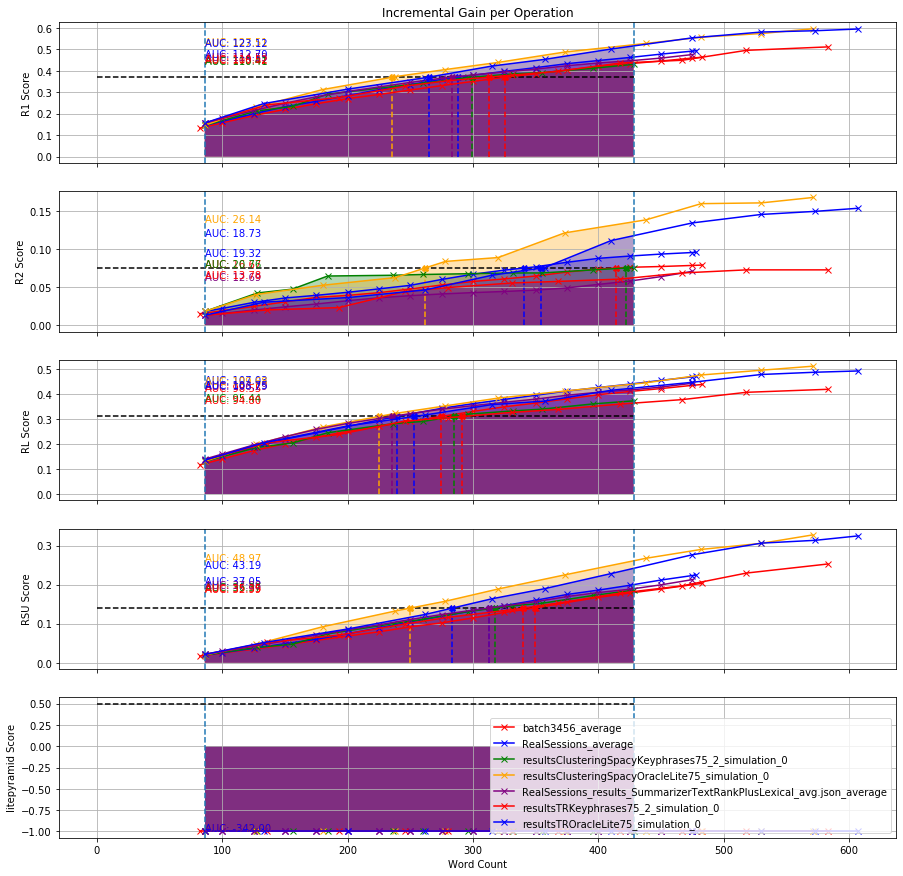

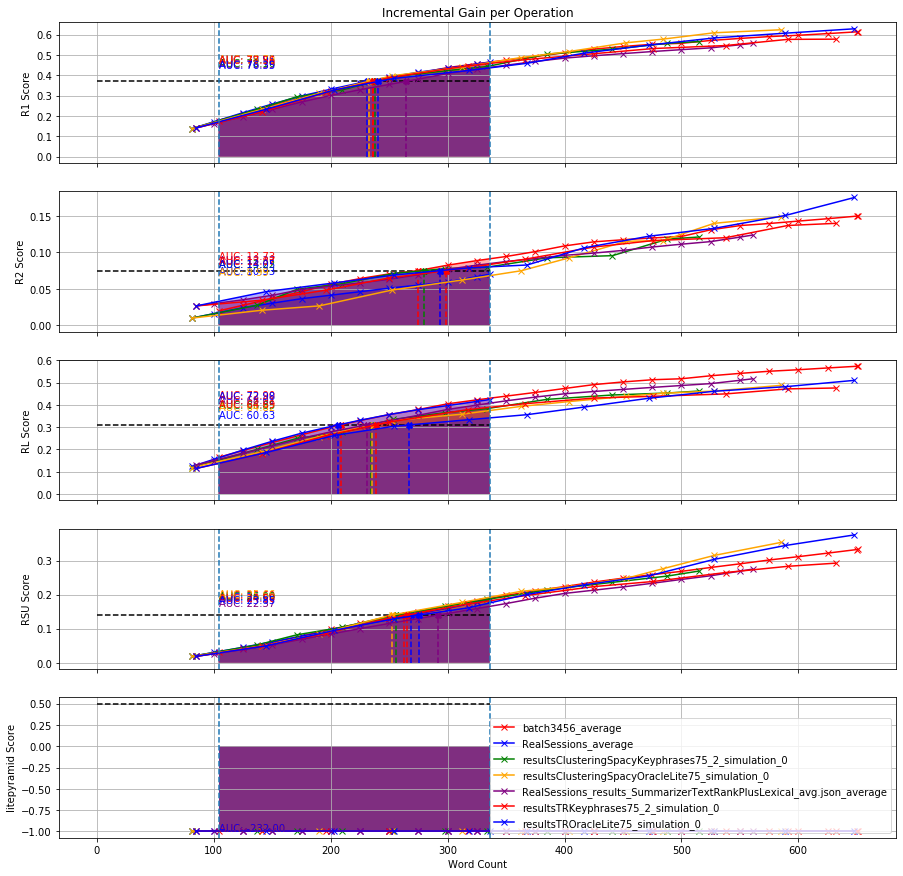

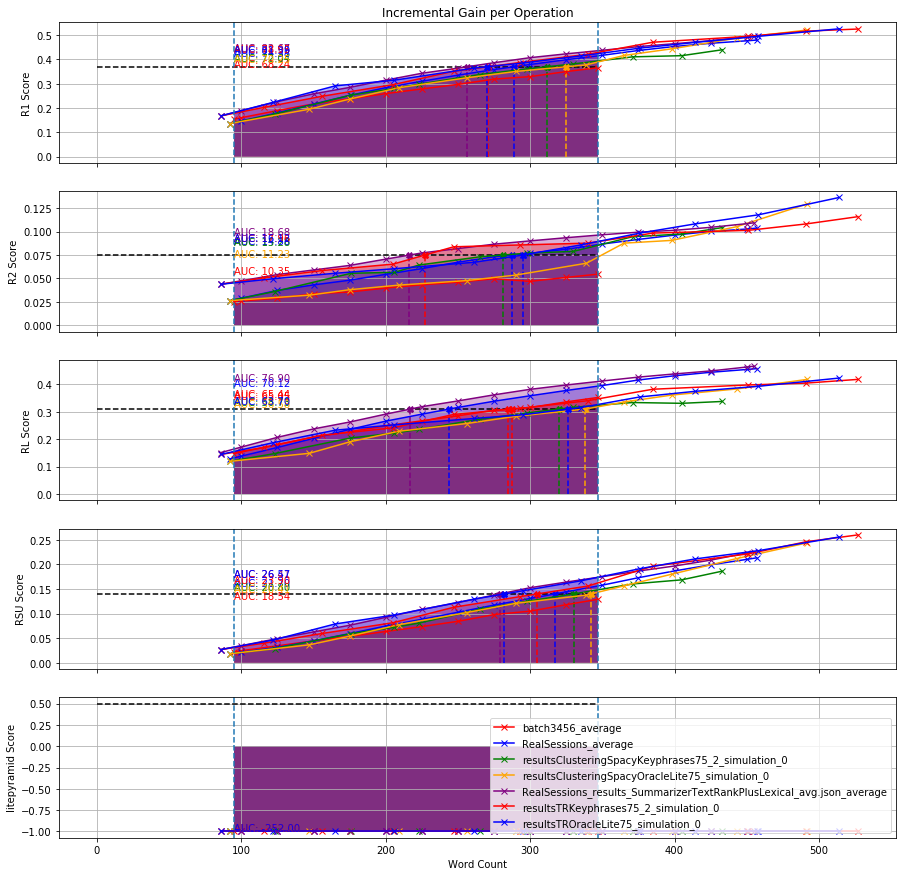

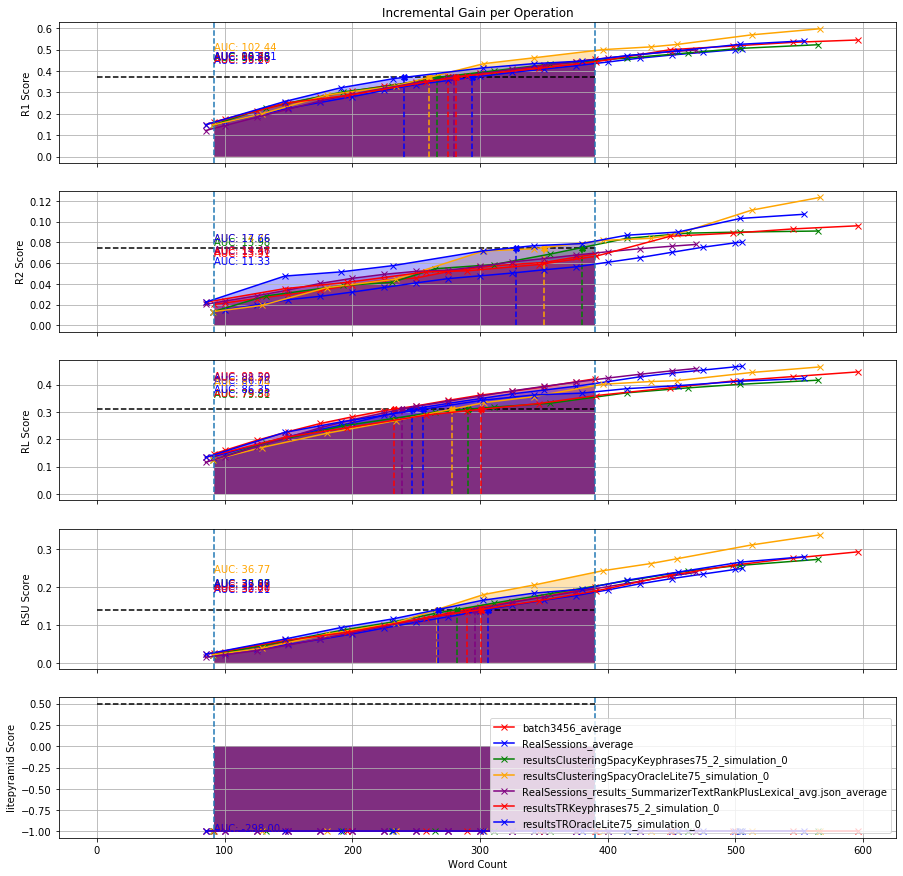

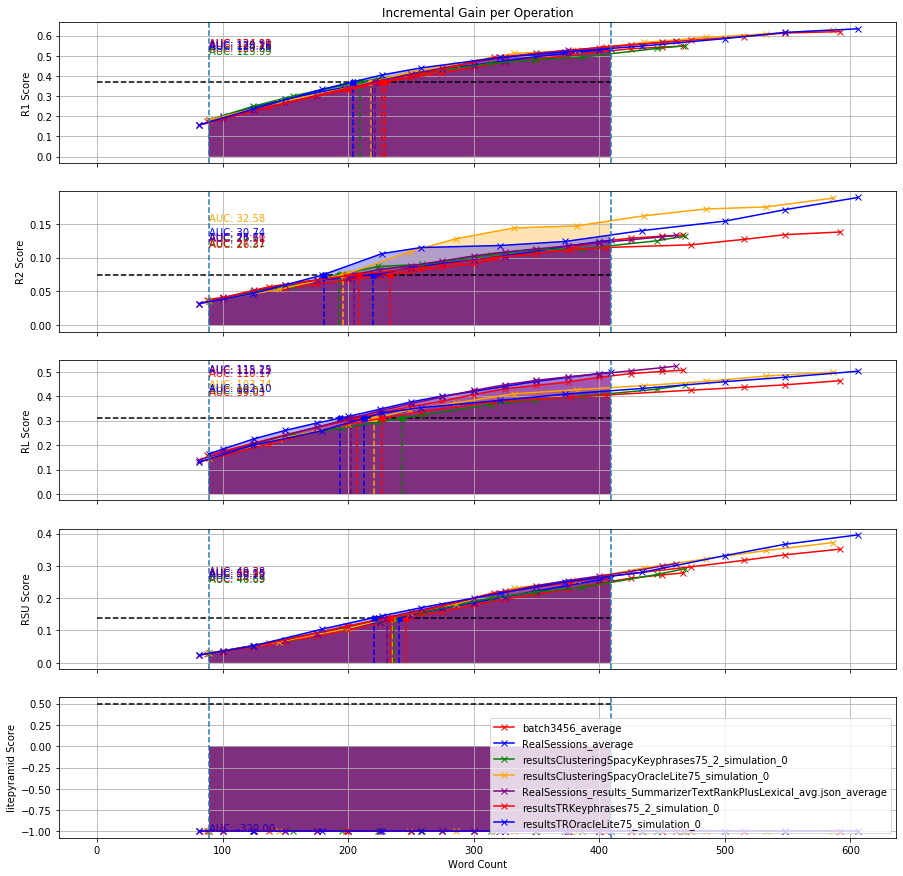

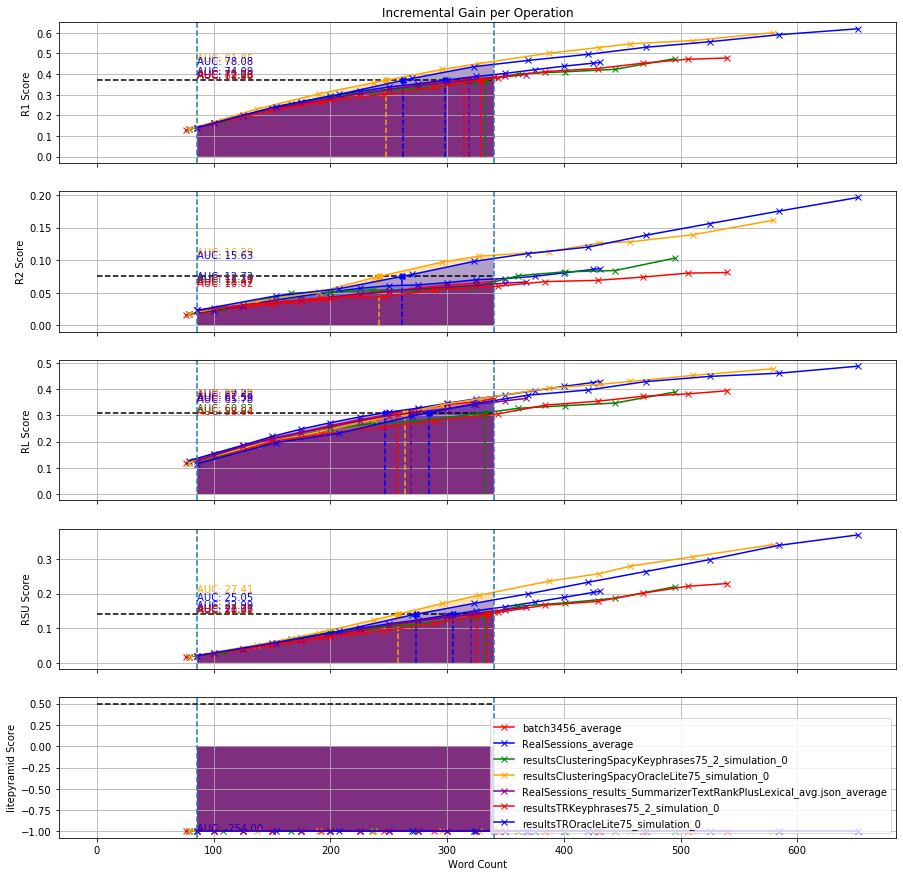

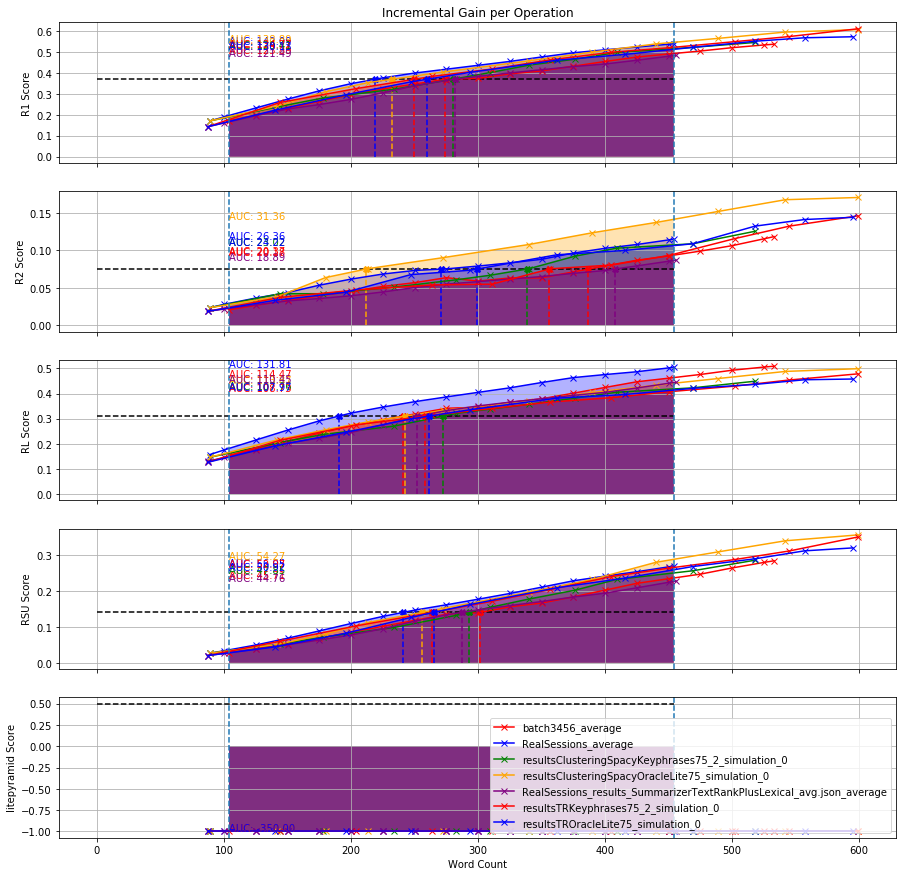

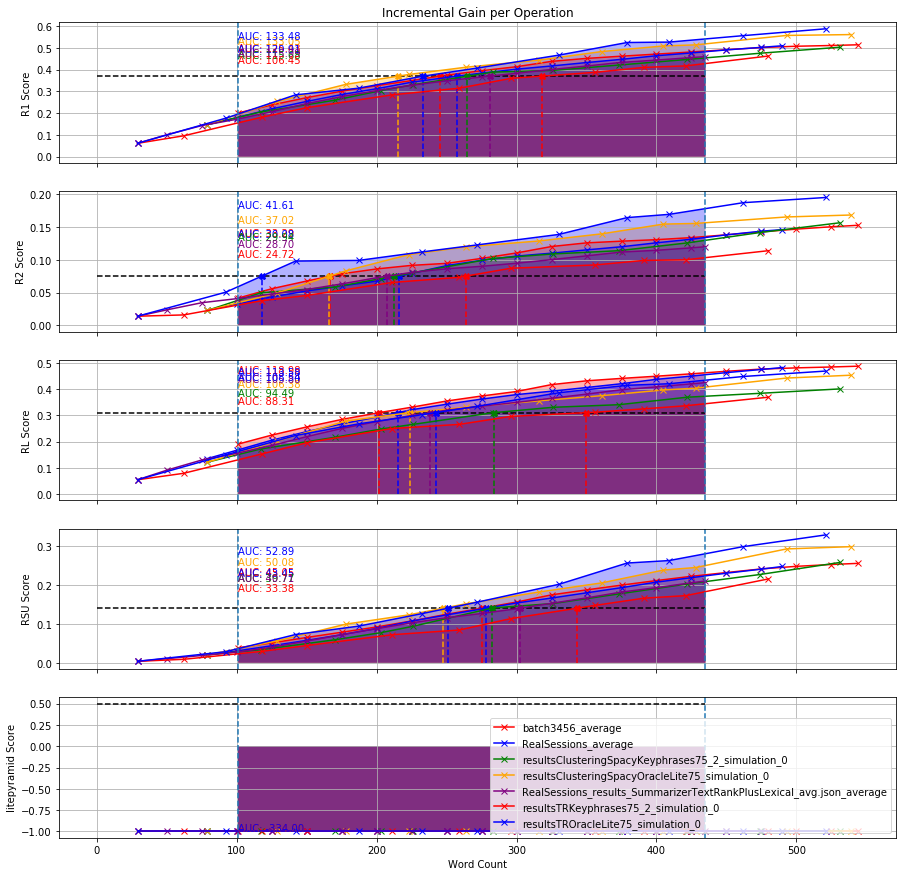

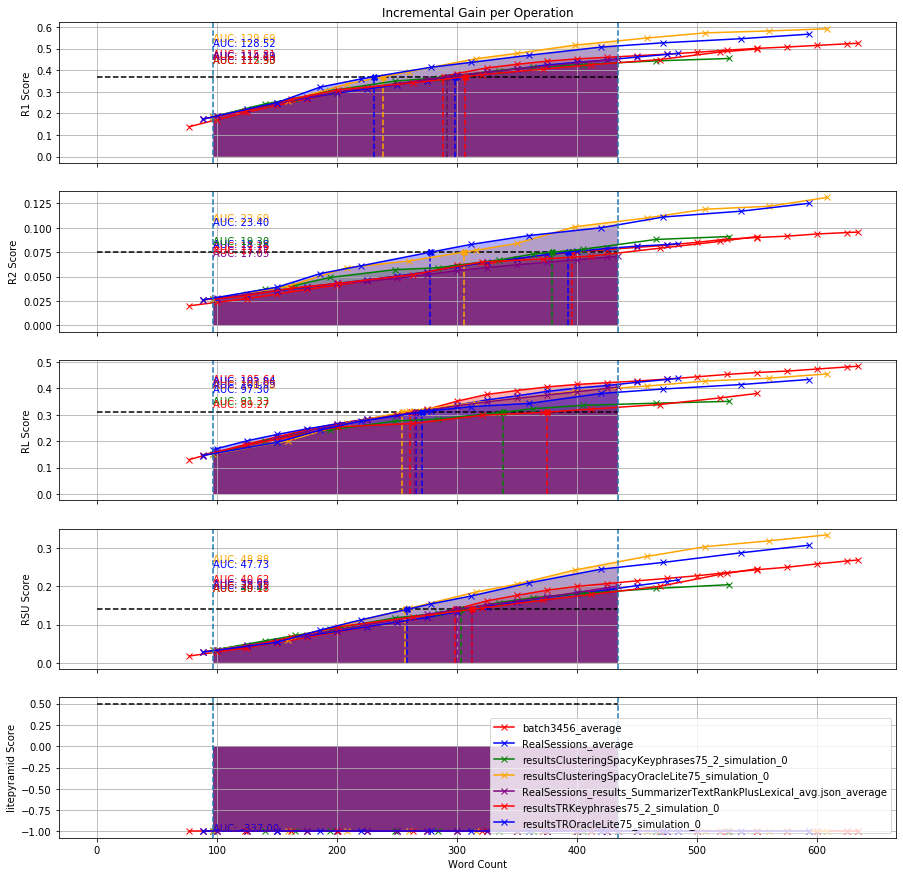

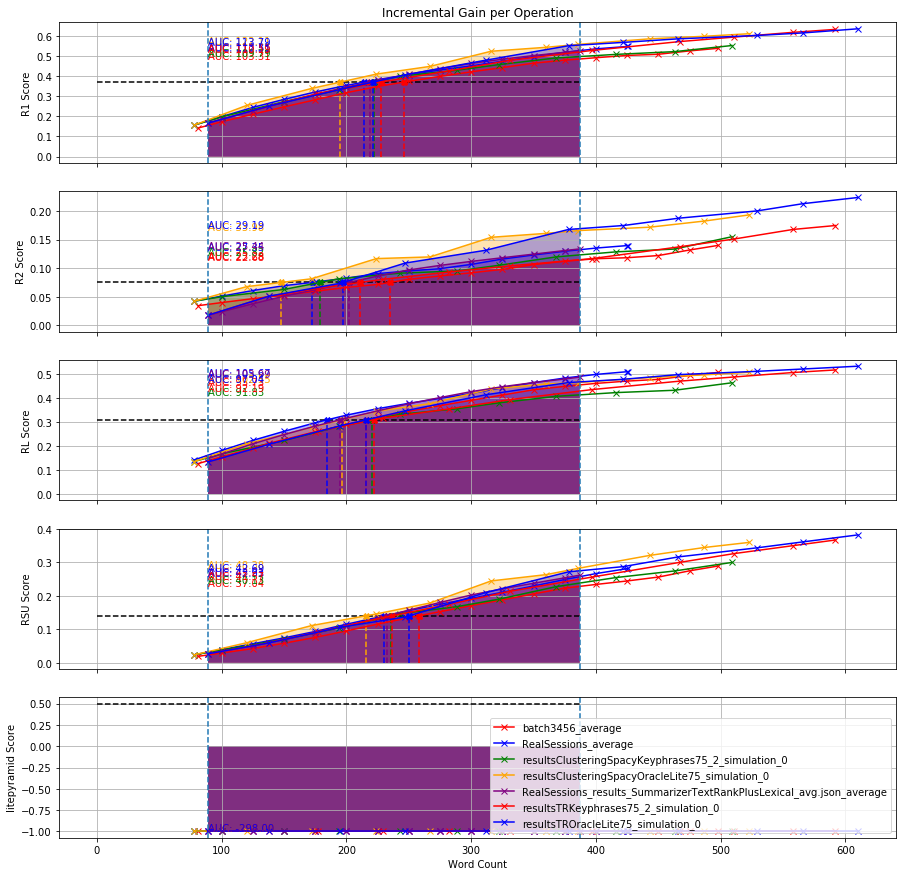

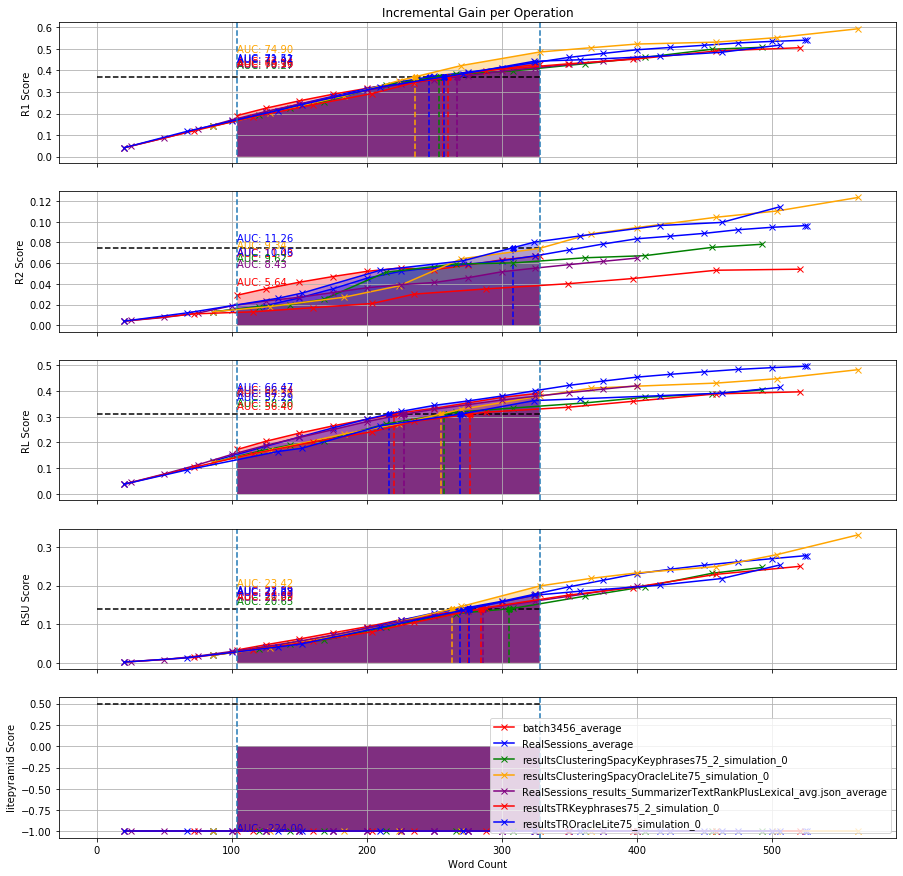

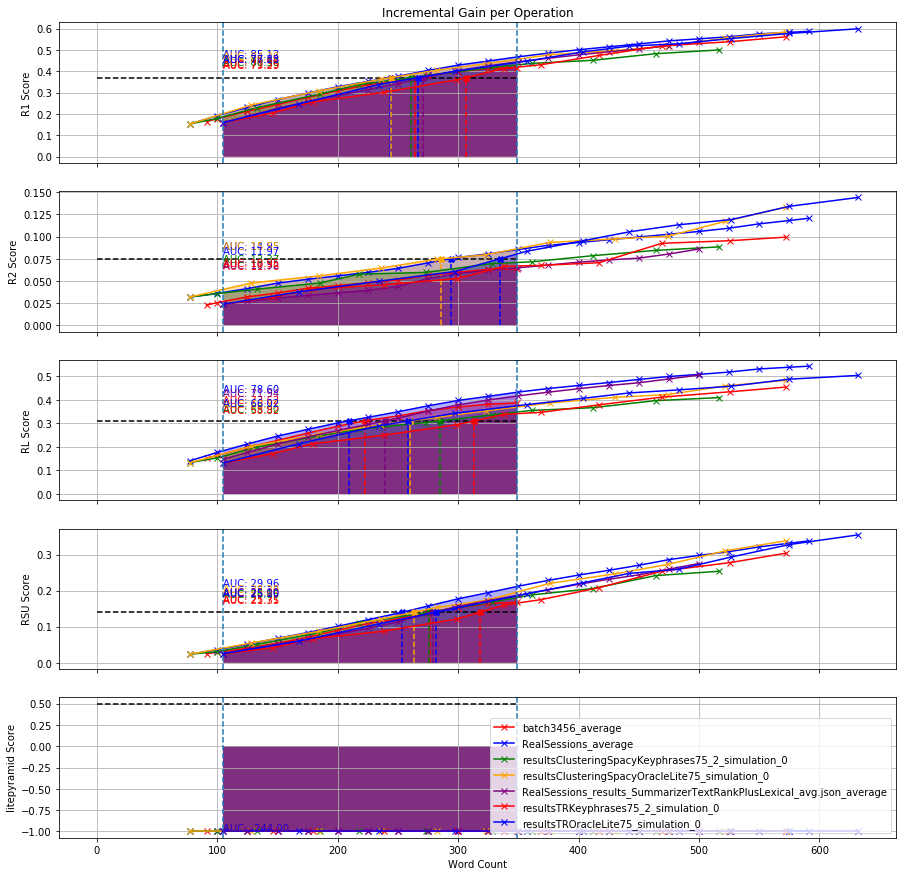

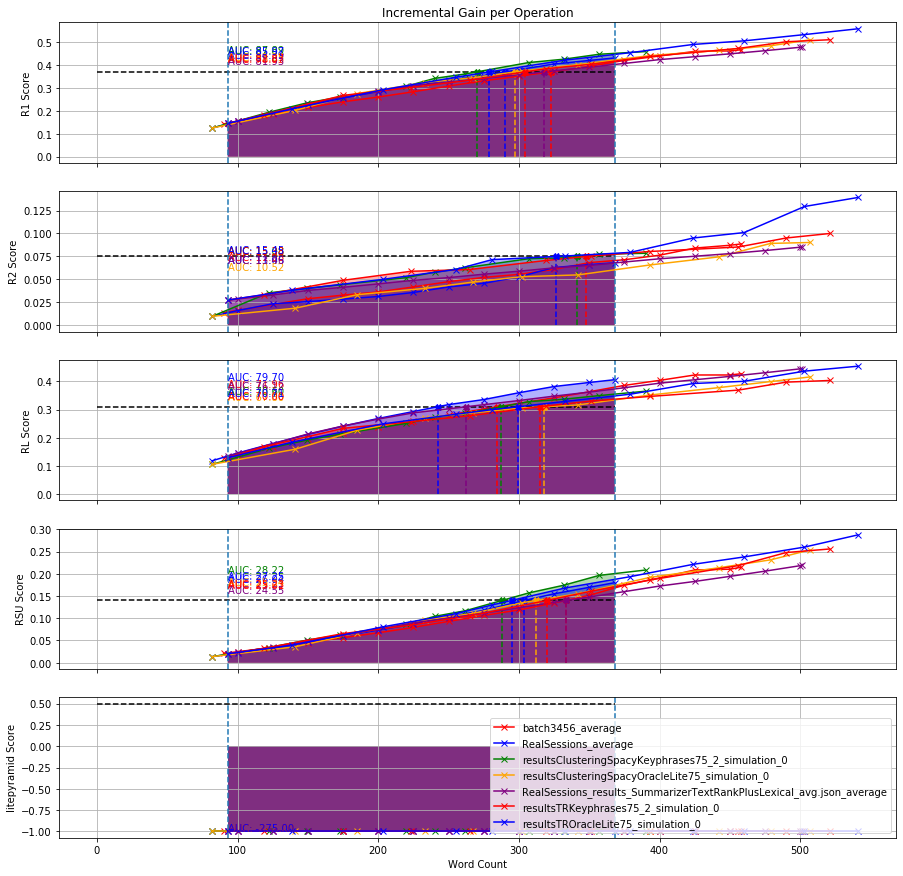

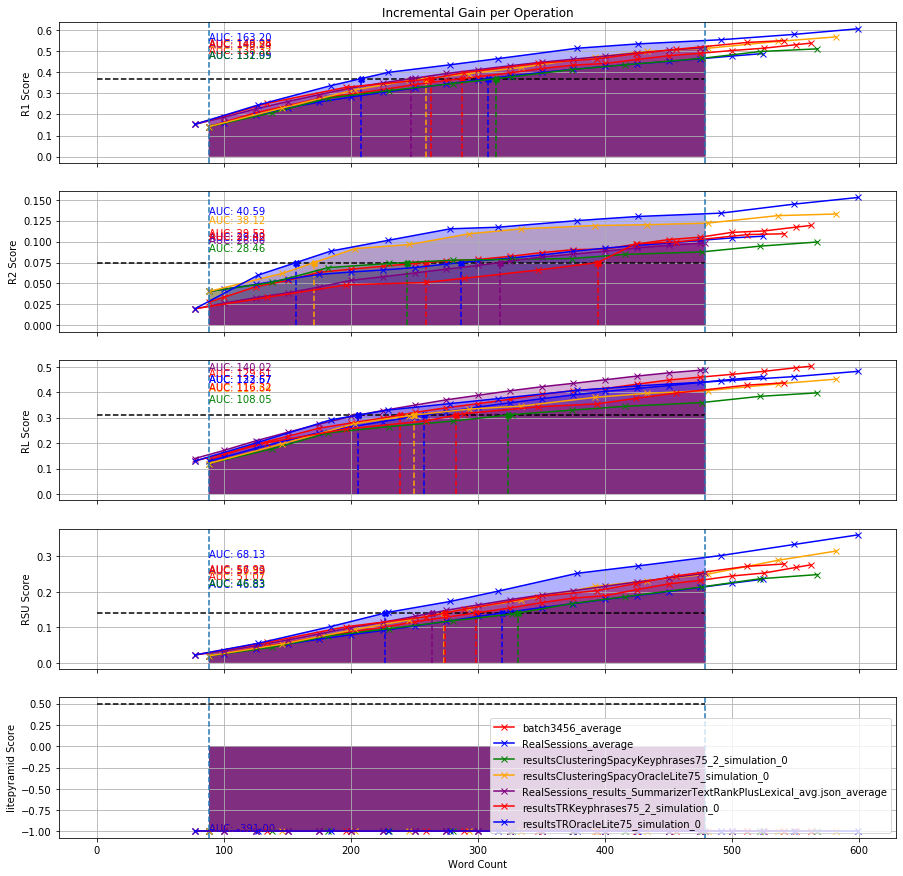

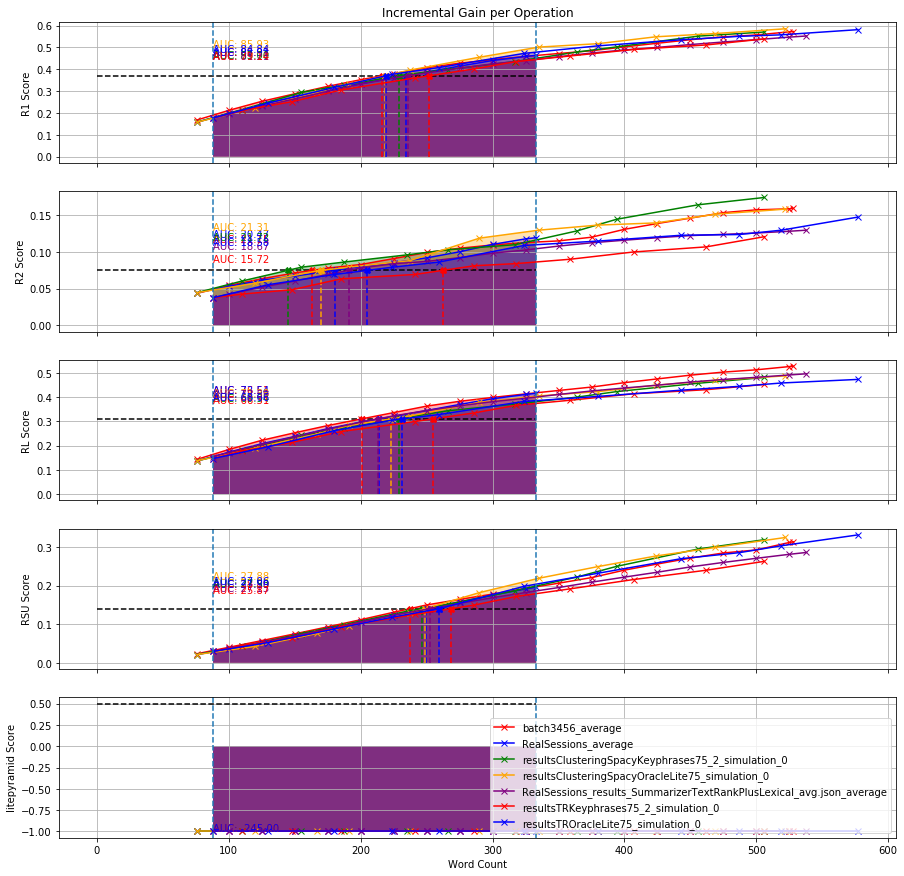

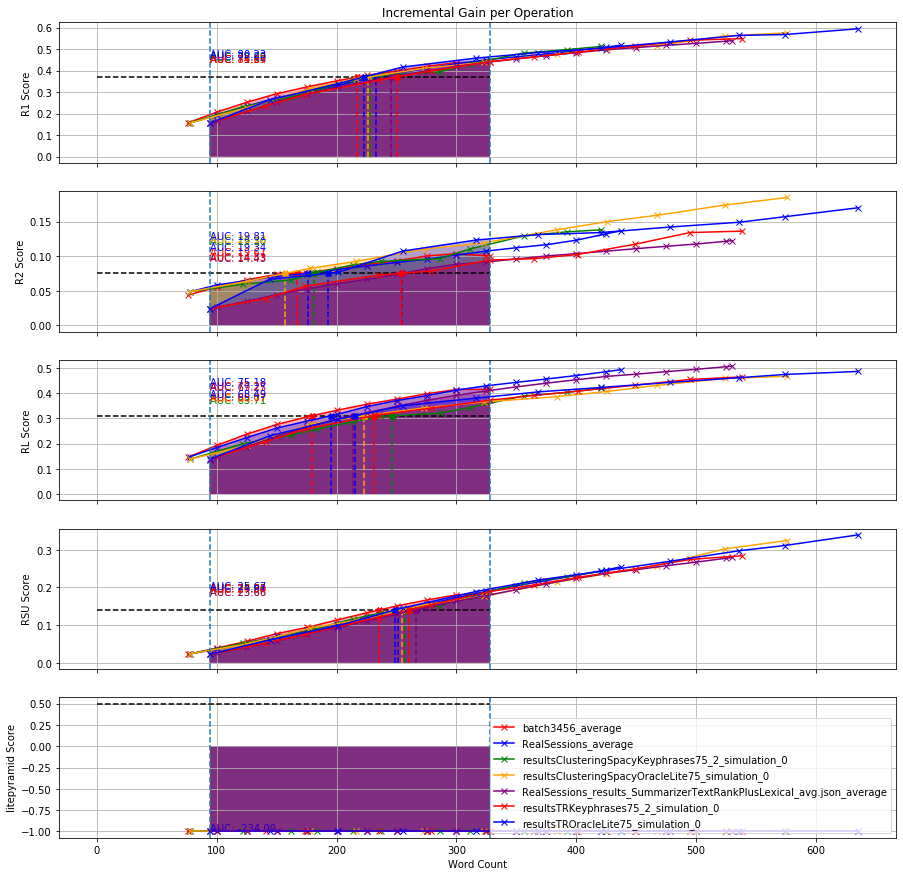

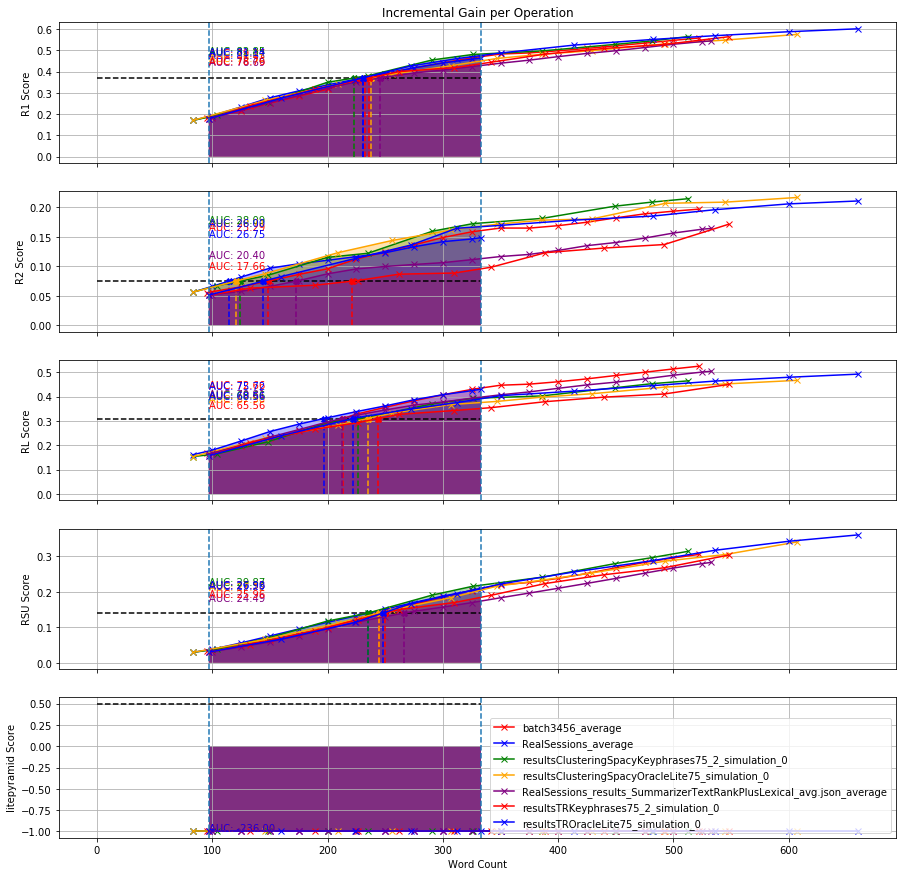

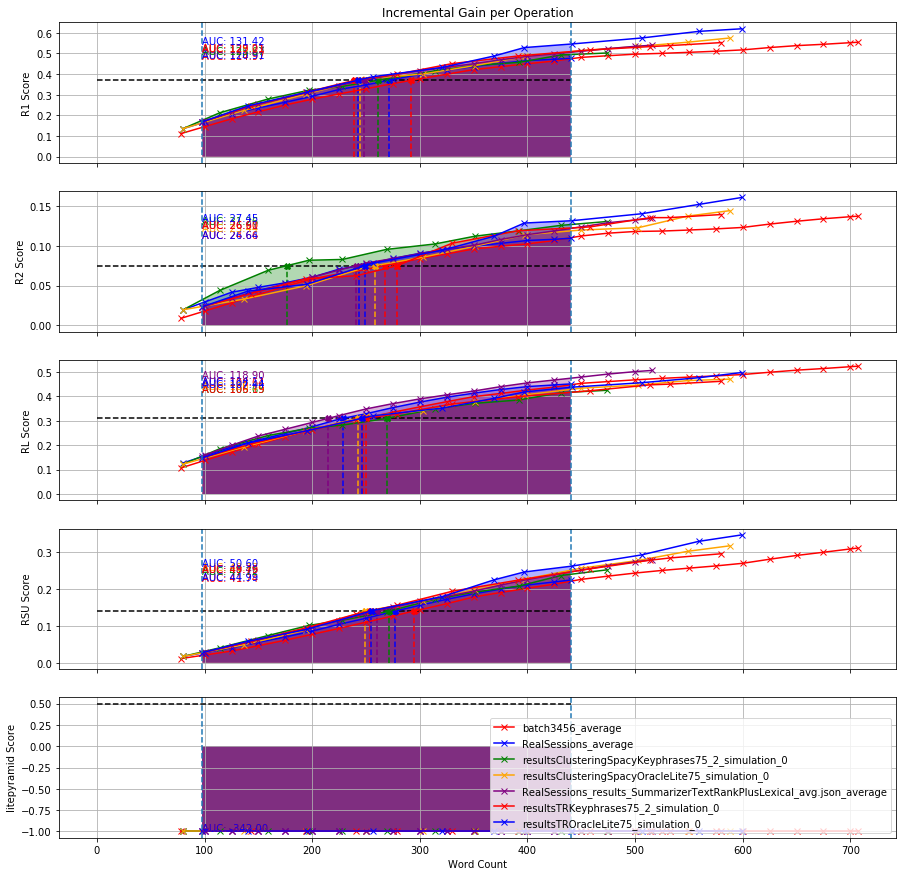

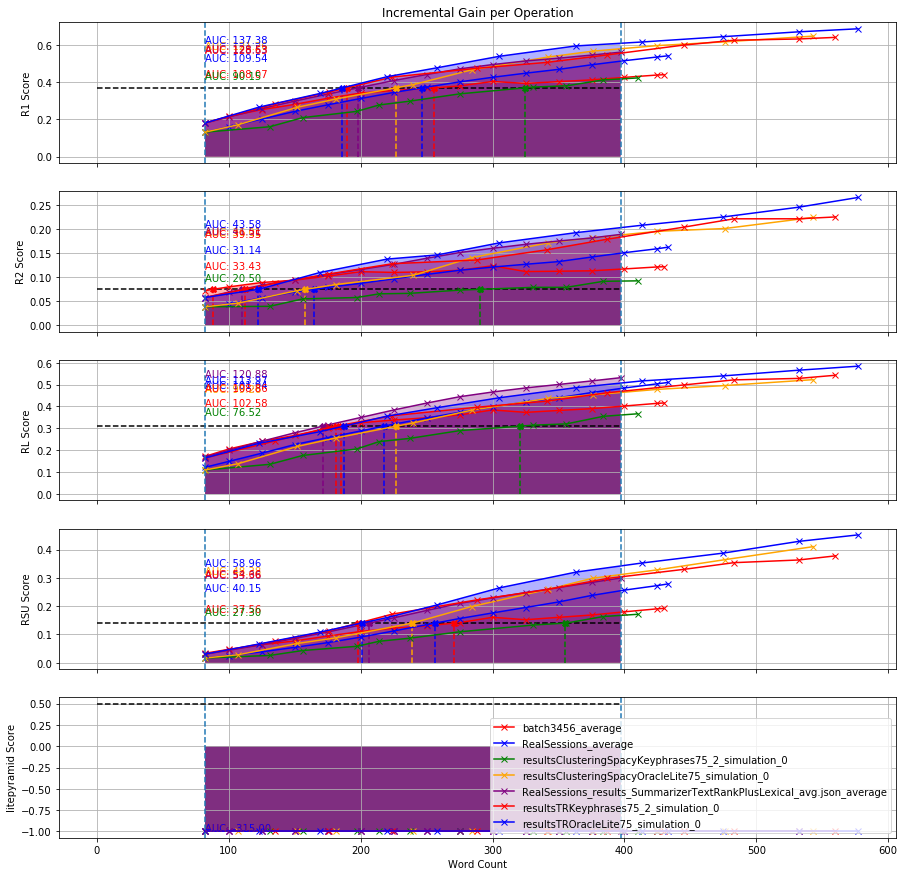

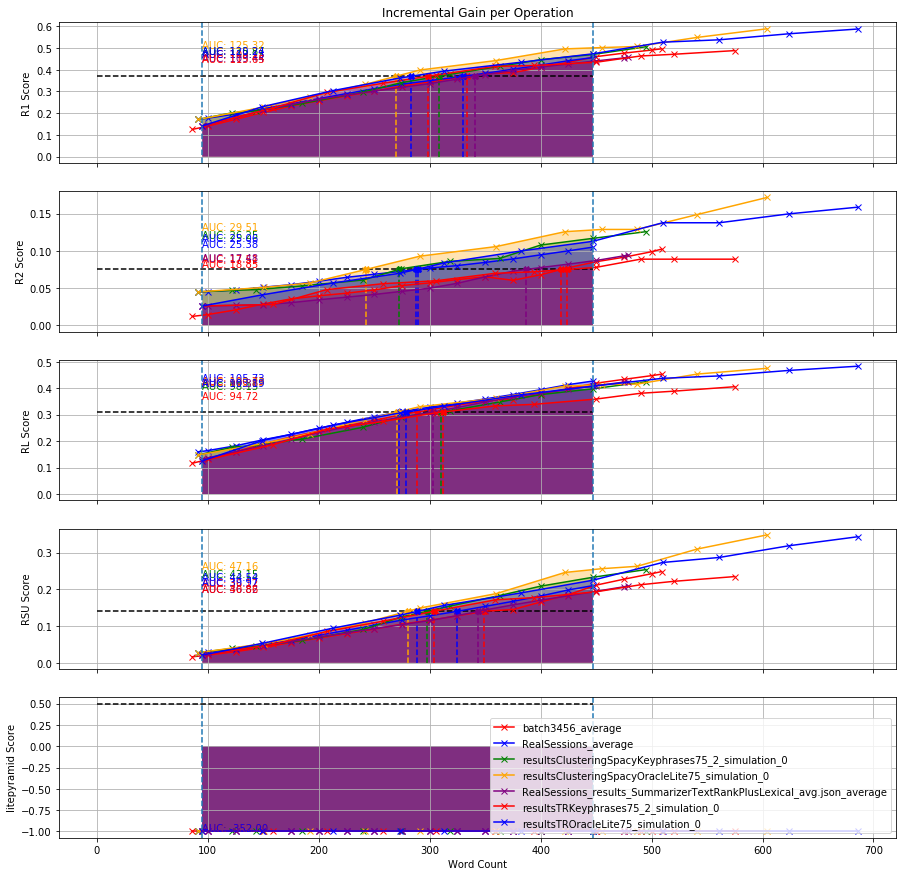

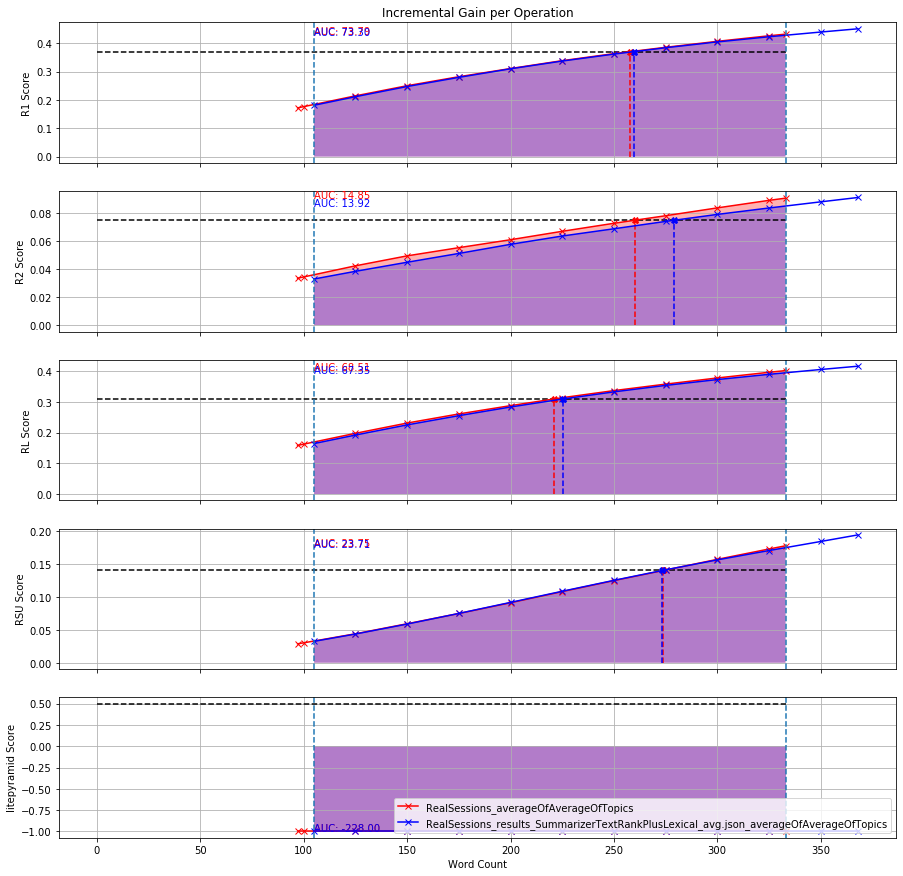

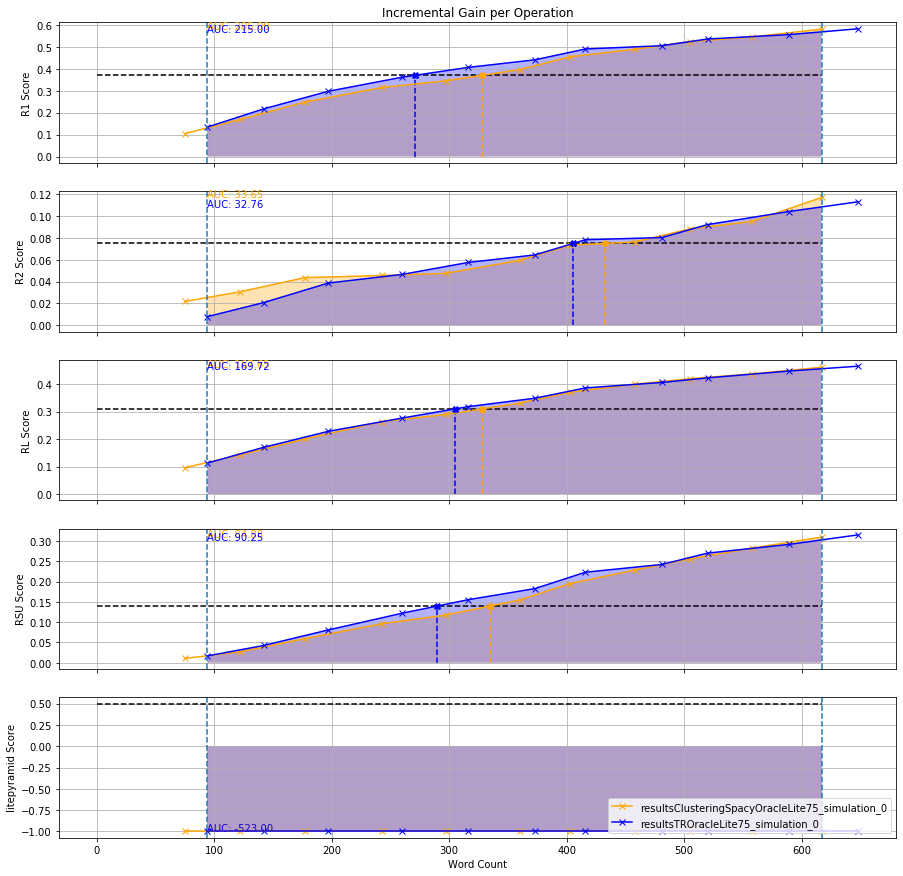

In [8]:
inputFiles = [
    '../MechanicalTurk/results/batch3456/results_SummarizerClustering_avg.json',
    '../MechanicalTurk/RealSessions/results_SummarizerClustering_avg.json',
    'simulations/fromServer/resultsClusteringSpacyKeyphrases75_2/results.json',
    'simulations/fromServer/resultsClusteringSpacyOracleLite75/results.json',
    '../MechanicalTurk/RealSessions/results_SummarizerTextRankPlusLexical_avg.json',
    'simulations/fromServer/resultsTRKeyphrases75_2/results.json',
    'simulations/fromServer/resultsTROracleLite75/results.json',
]

outputFolder = '../MechanicalTurk/RealSessions/comparisonAvg'

compareResults(inputFiles, outputFolder)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:231: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyError: 'D0650'

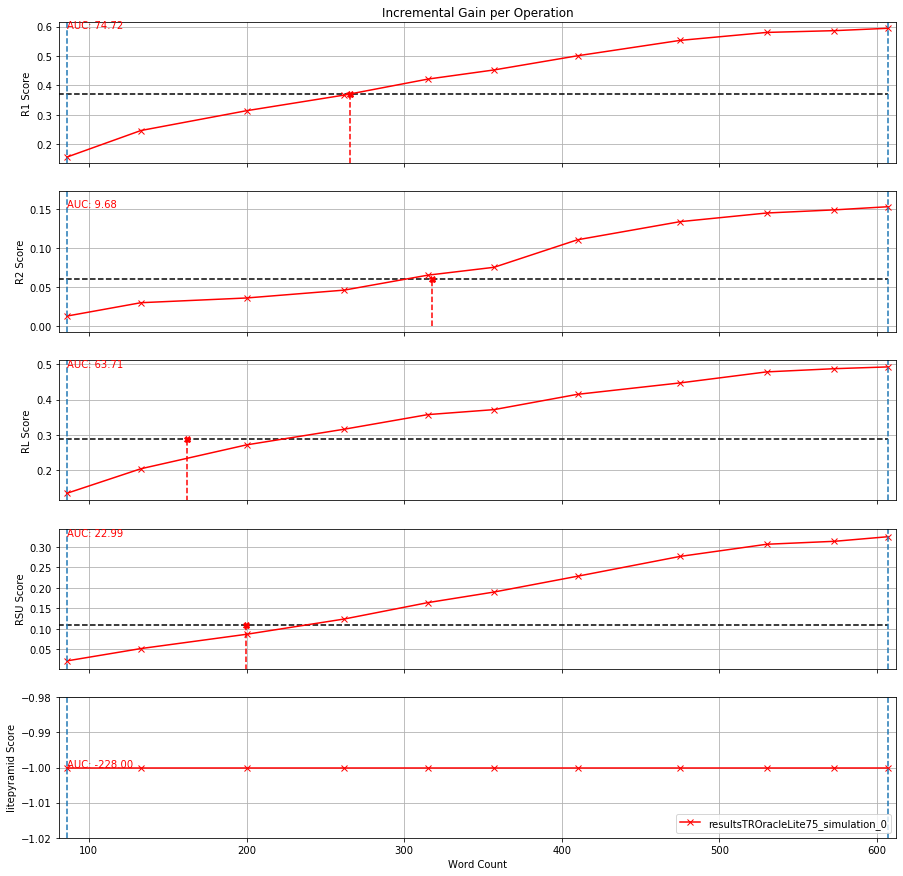

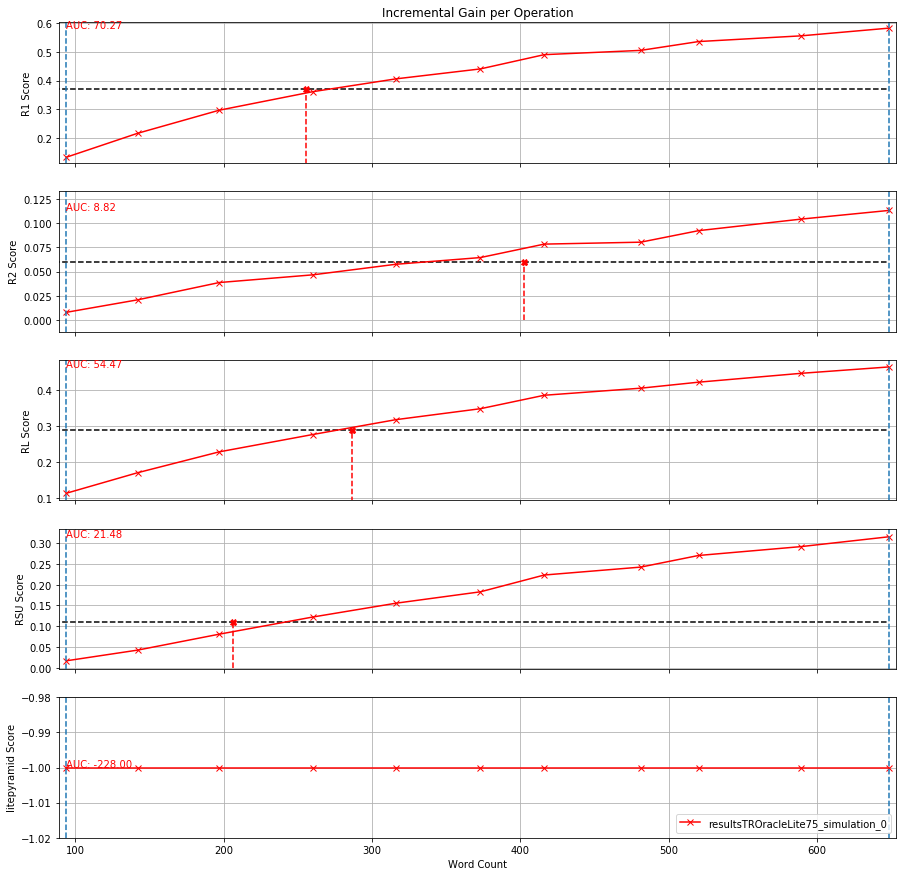

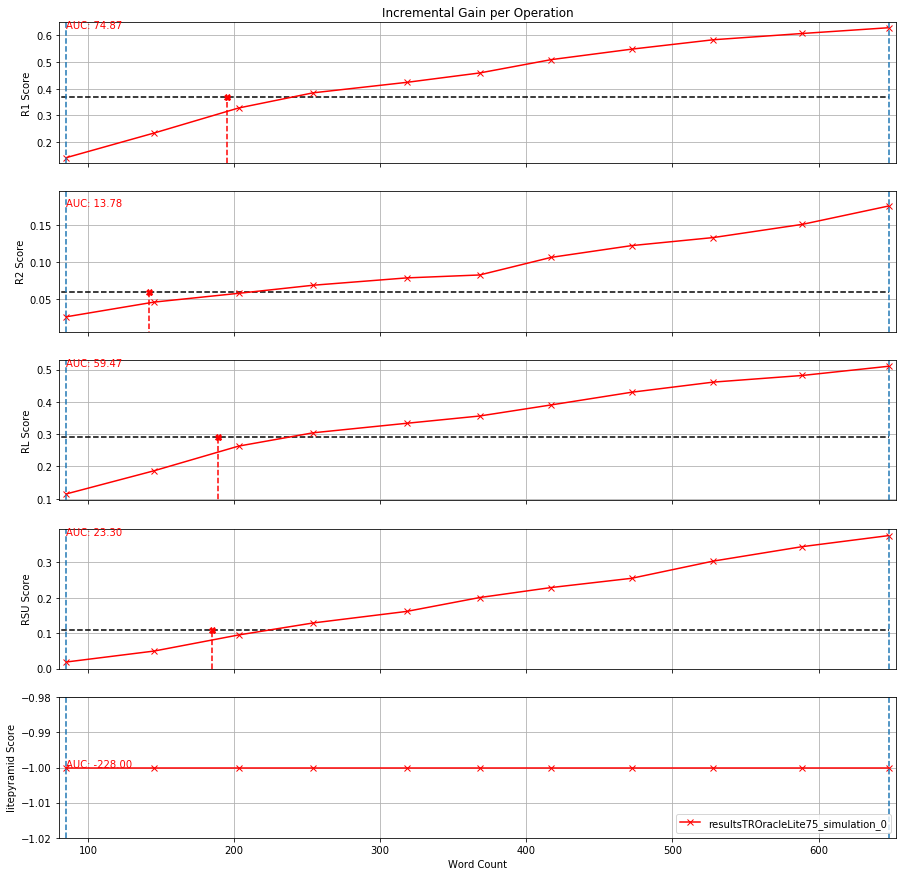

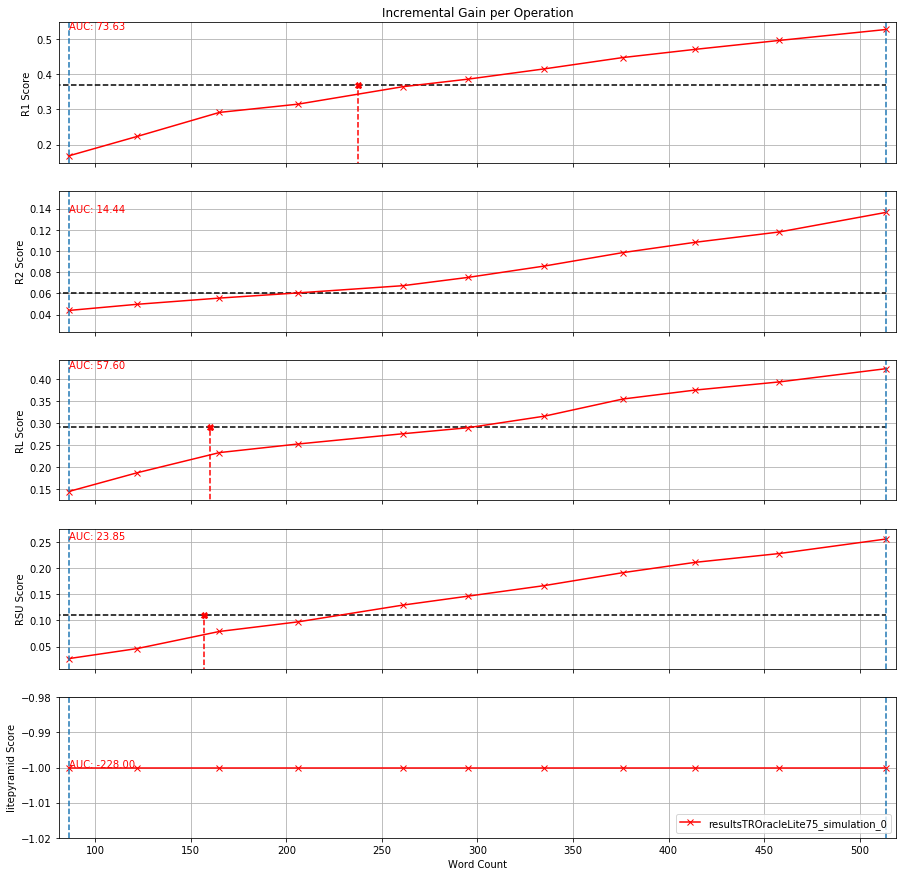

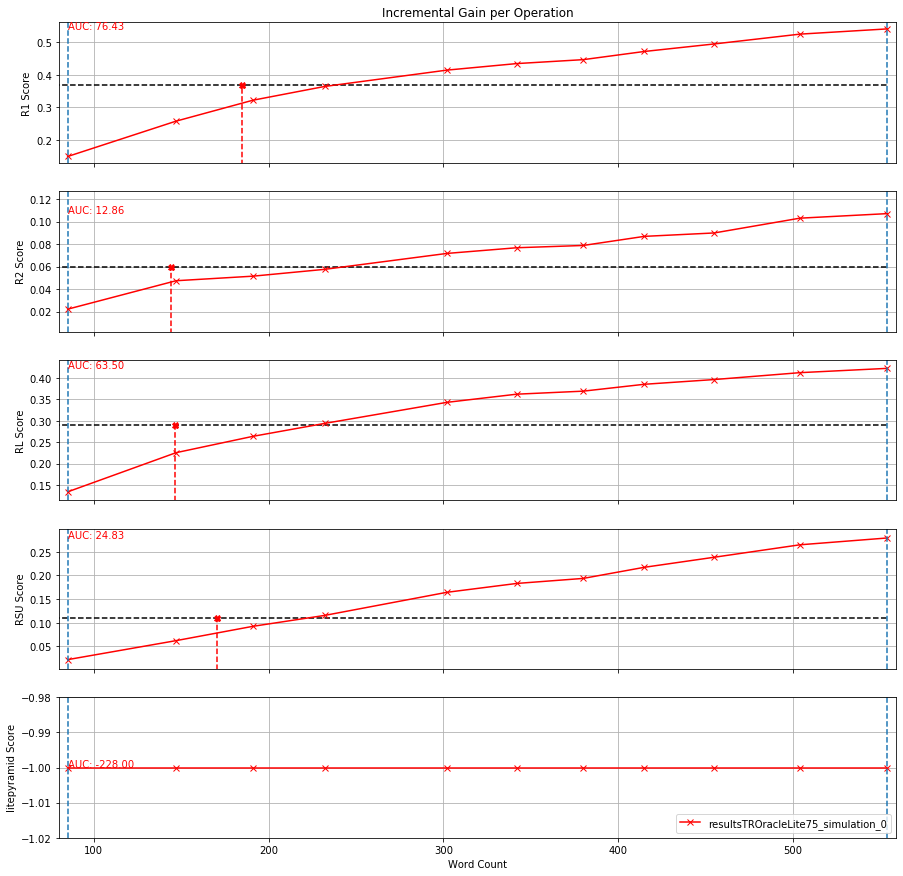

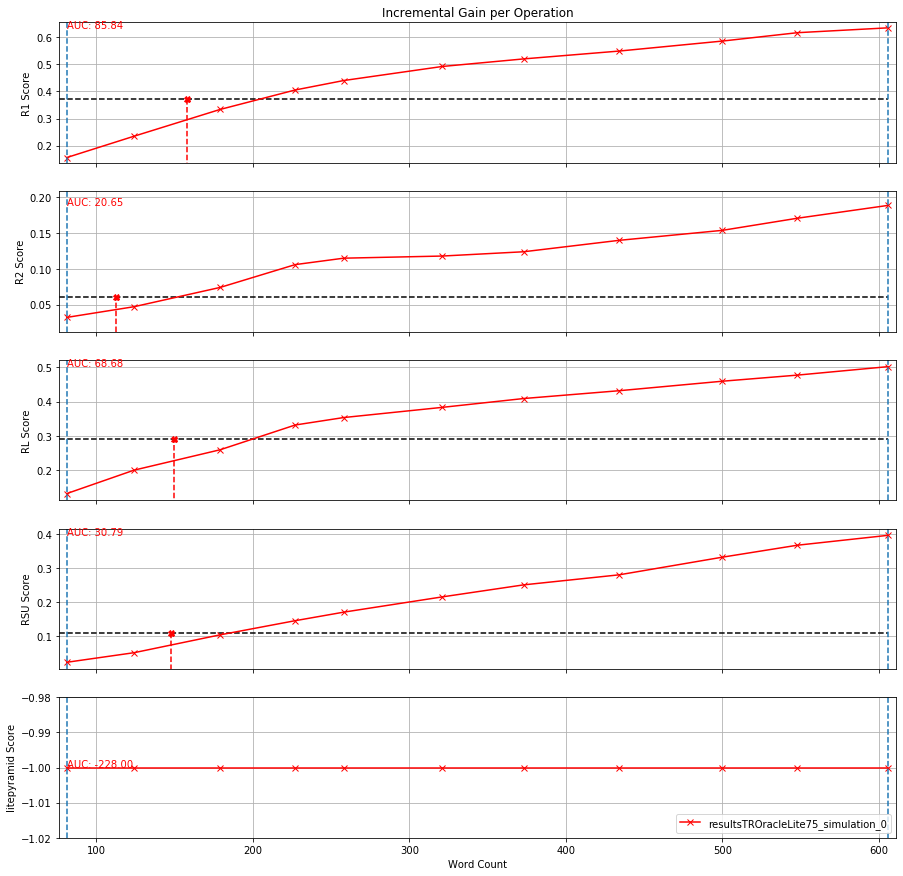

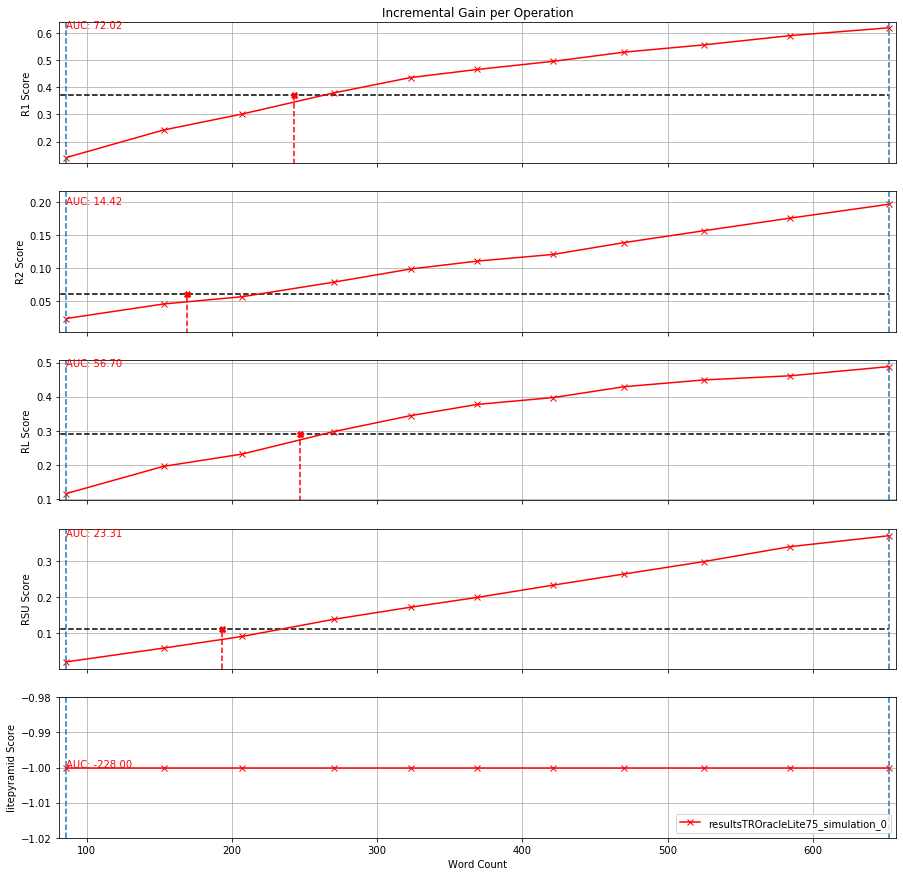

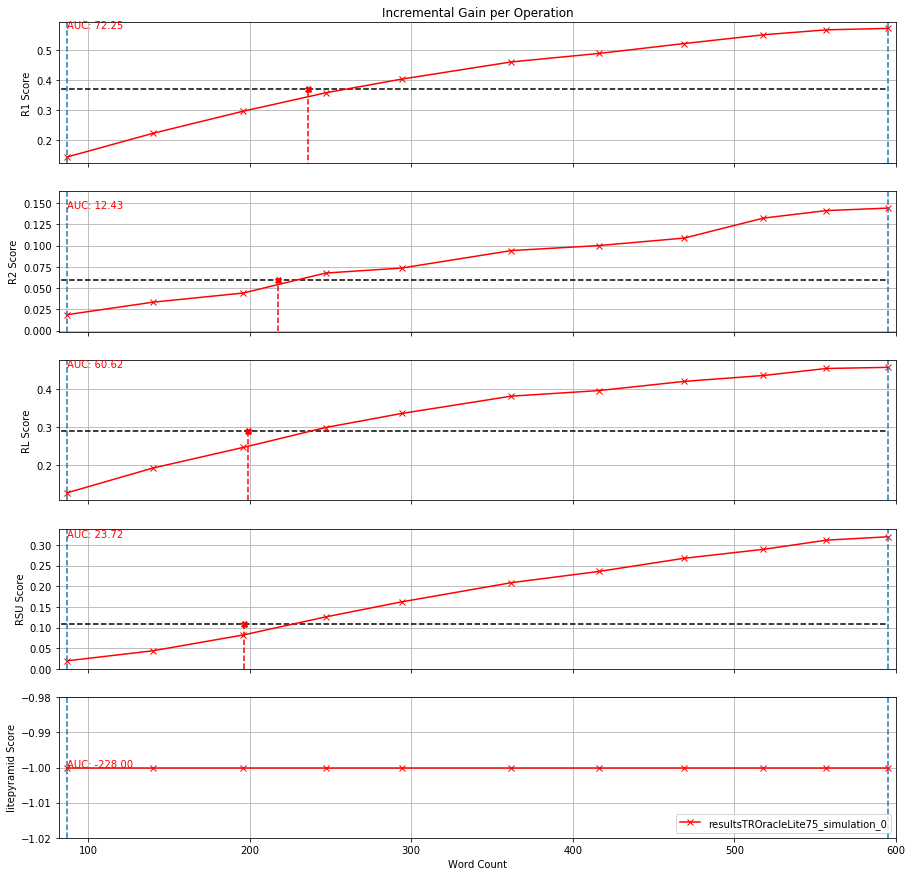

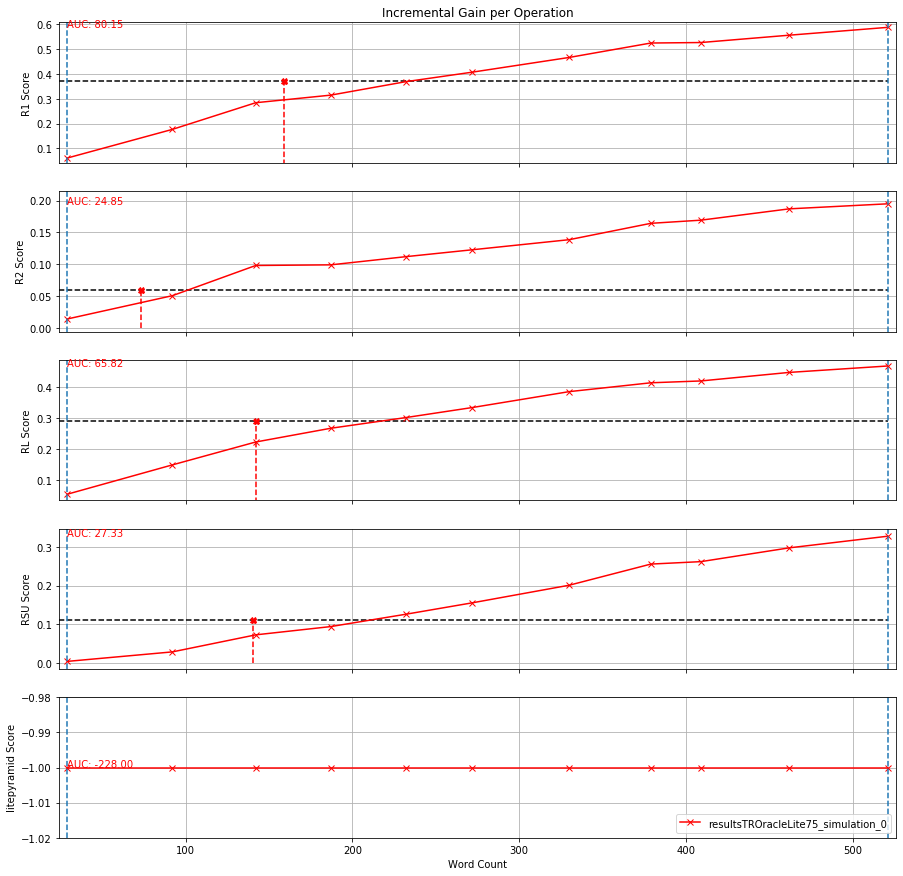

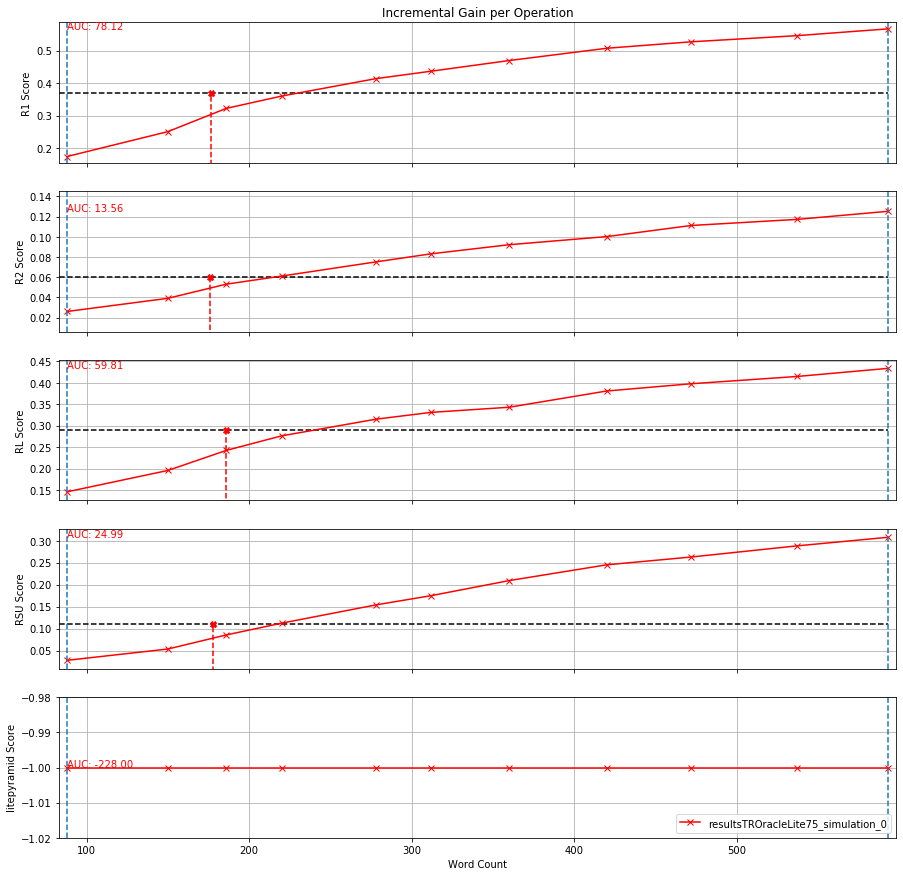

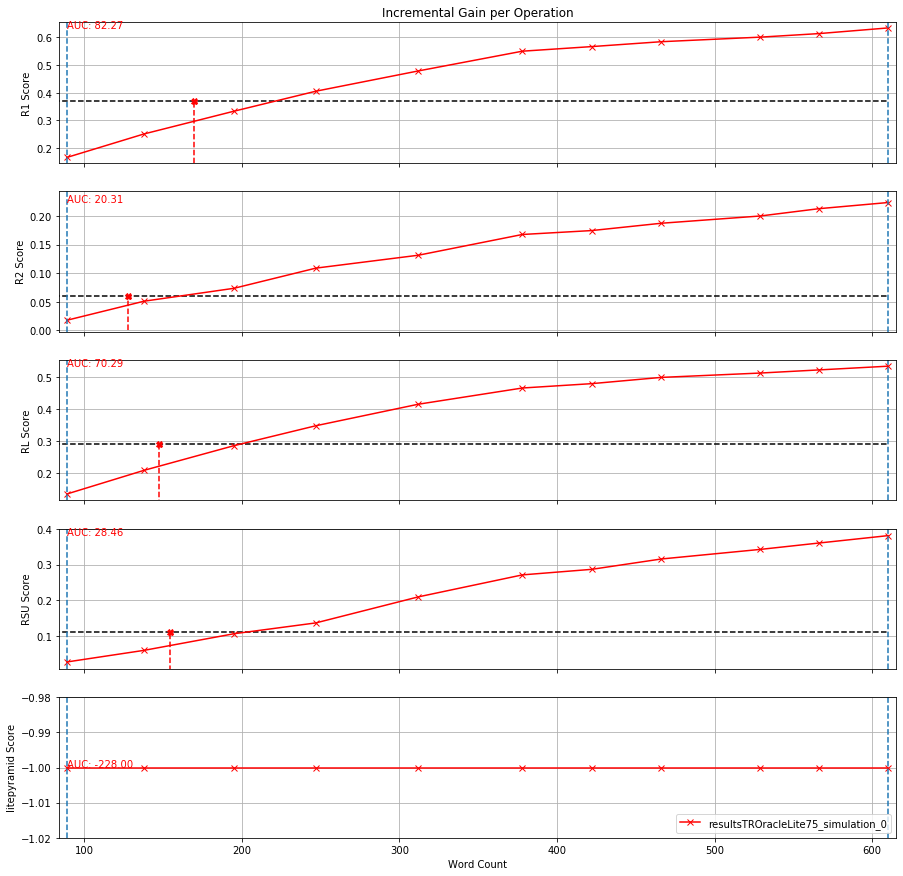

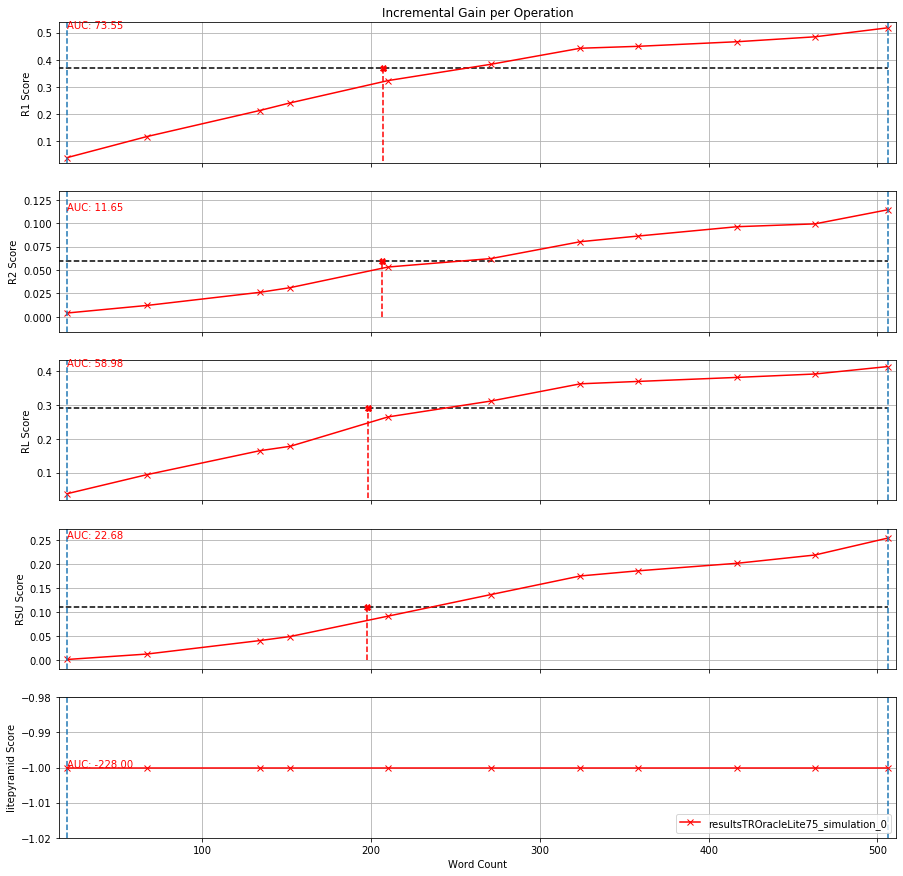

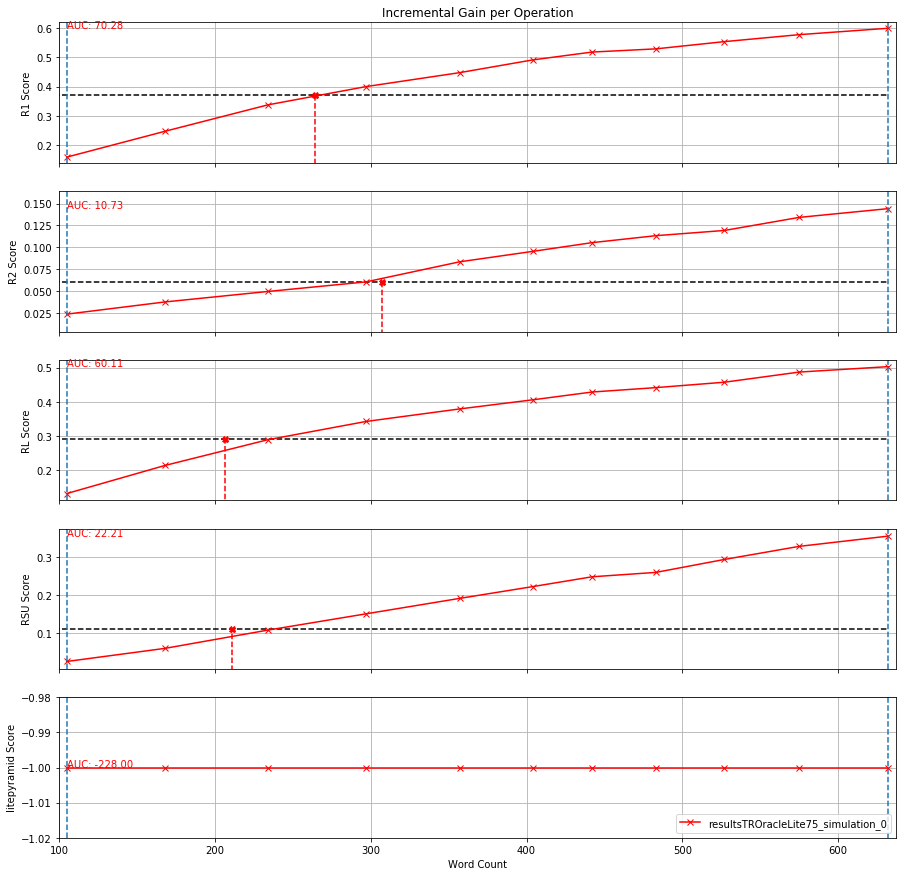

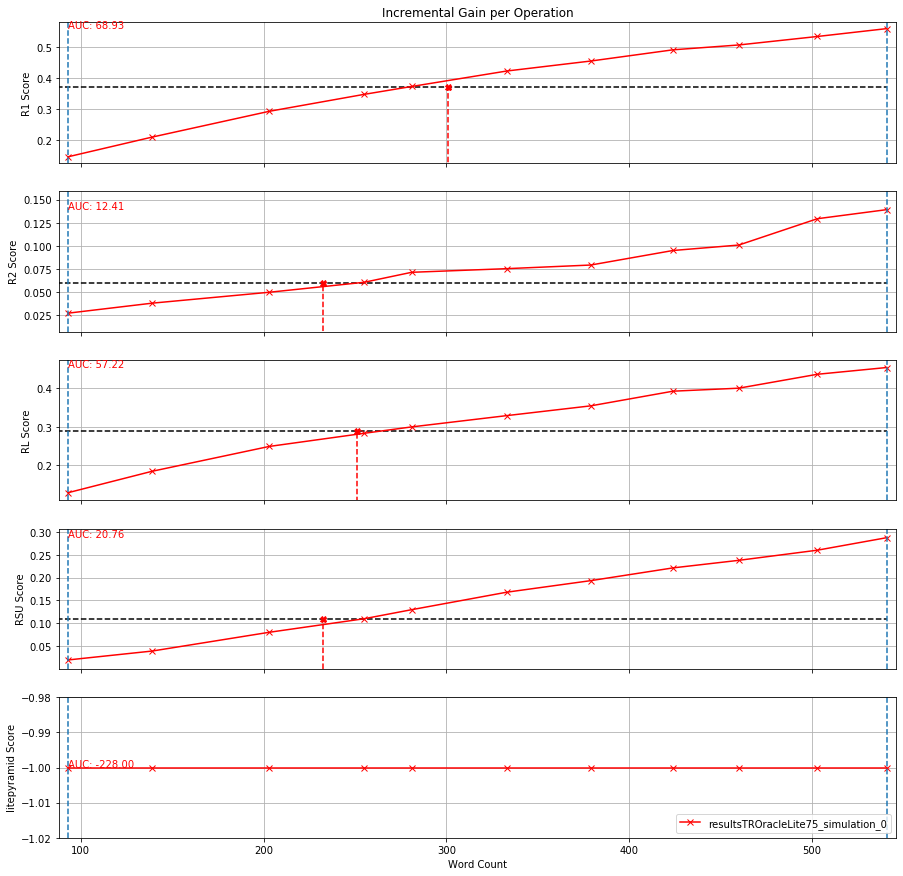

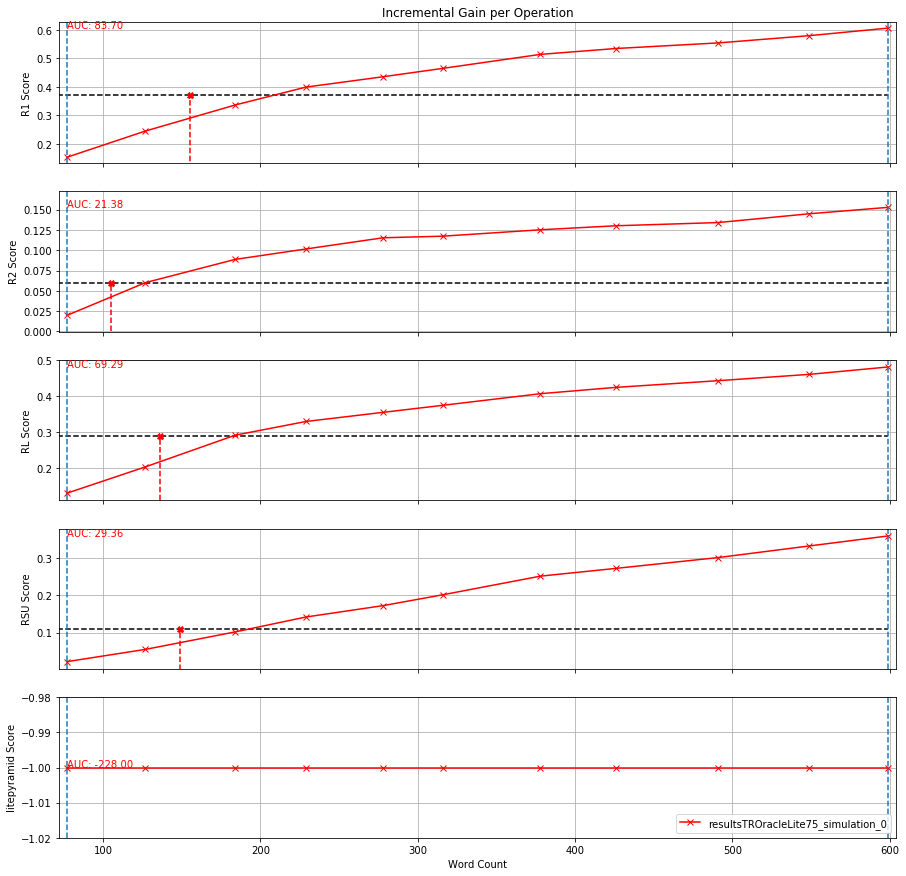

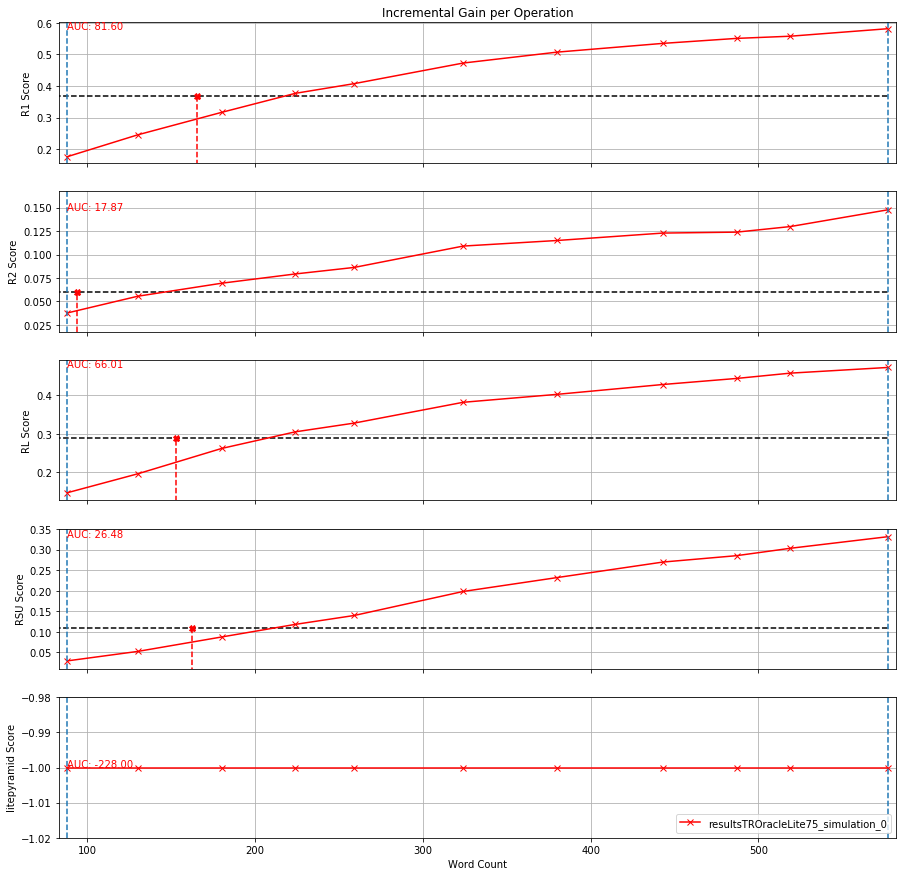

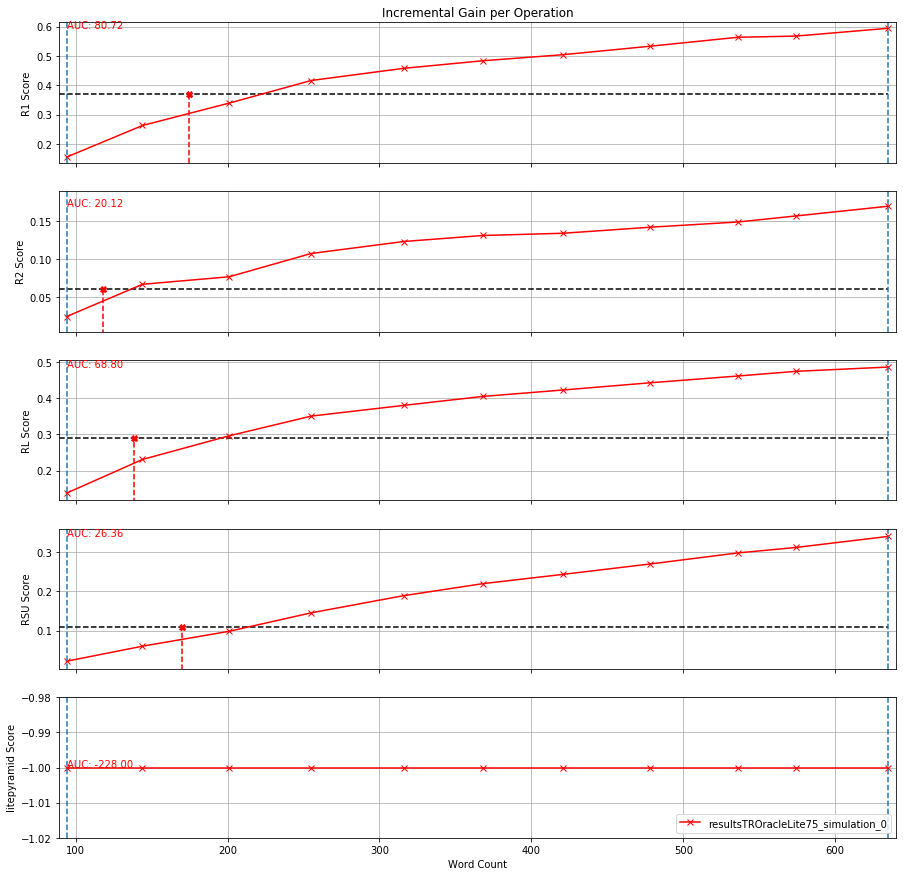

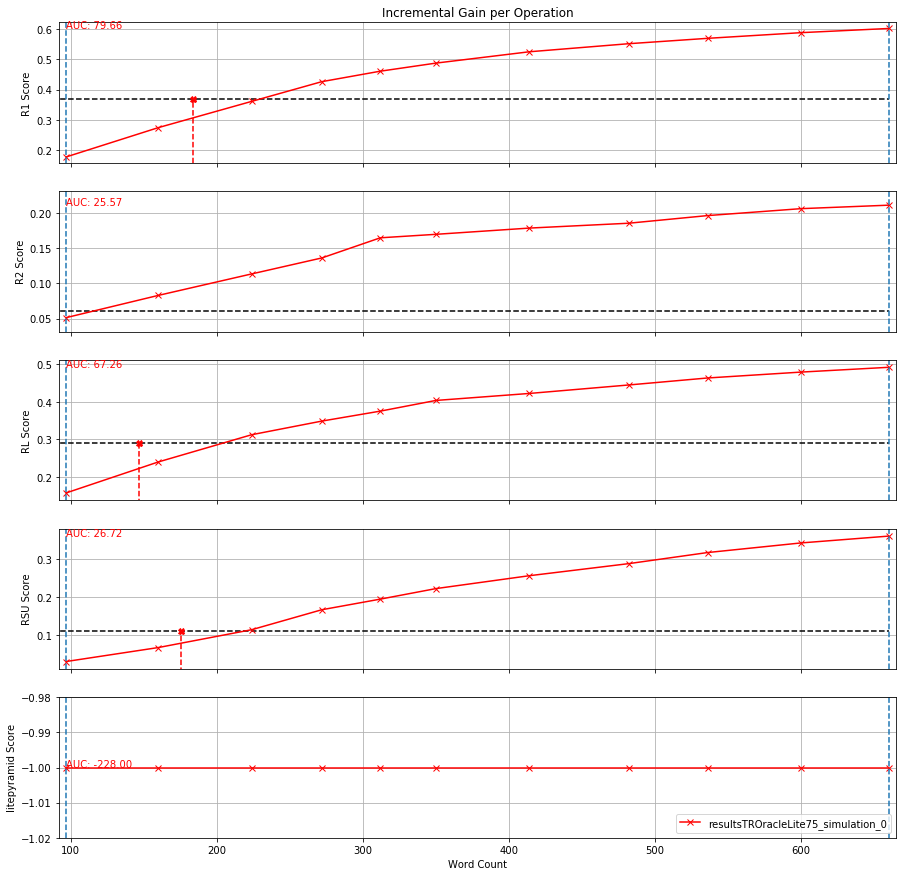

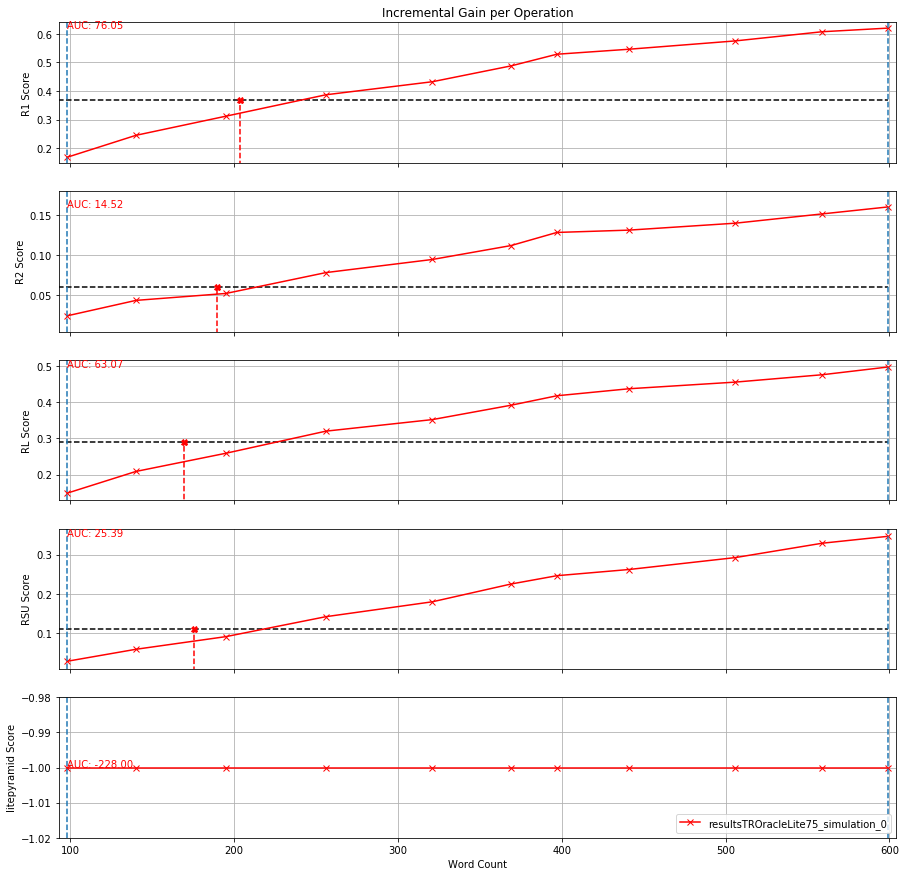

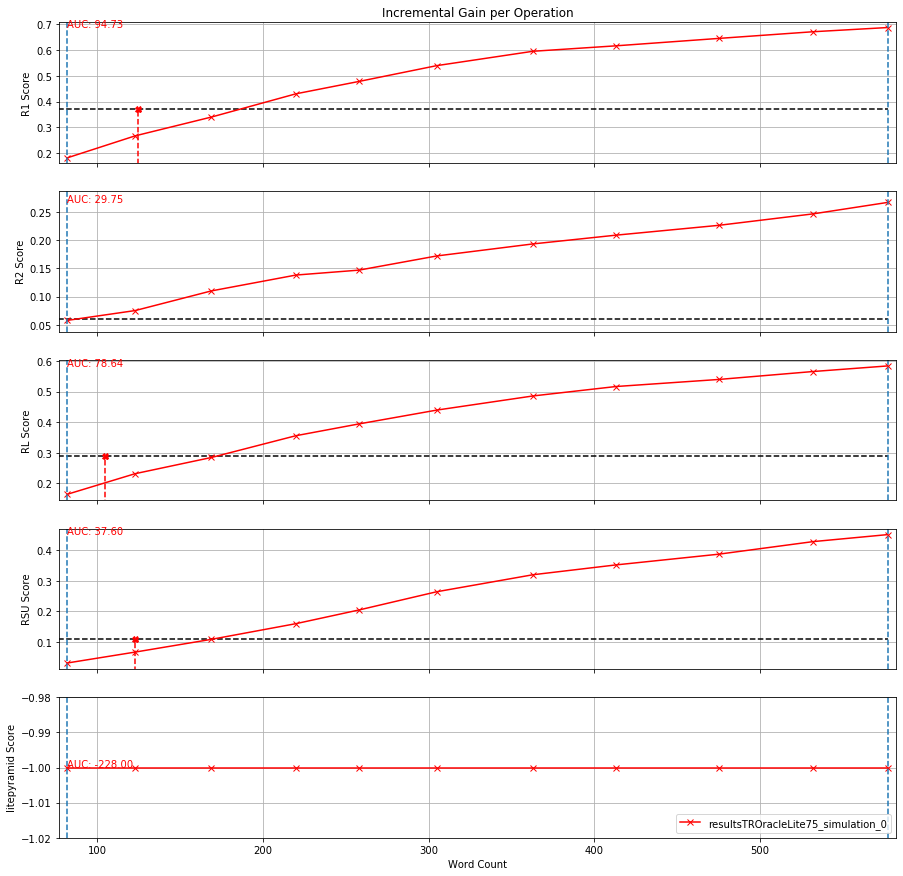

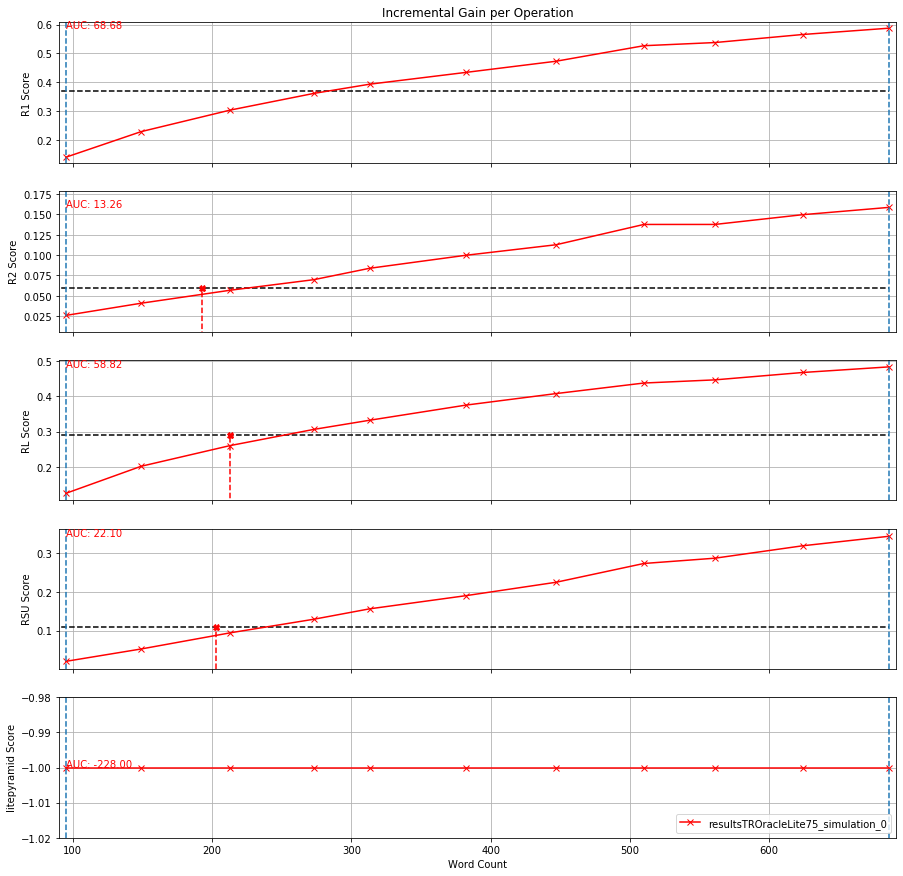

In [46]:
XMIN_AUC = 105 # float('inf')
XMAX_AUC = 333 # float('-inf')

inputFiles = [
    #'../MechanicalTurk/RealSessions/results_SummarizerClustering.json'
    #'../MechanicalTurk/RealSessions/results_SummarizerTextRankPlusLexical.json'
    #'../MechanicalTurk/results/batch3456/results_SummarizerClustering.json'
    #'simulations/fromServer/resultsClusteringSpacyKeyphrases75_2/results.json'
    #'simulations/fromServer/resultsClusteringSpacyOracleLite75/results.json'
    #'simulations/fromServer/resultsTRKeyphrases75_2/results.json'
    'simulations/fromServer/resultsTROracleLite75/results.json'
    
    #'../MechanicalTurk/RealSessions/results_SummarizerClustering_avg.json',
    #'../MechanicalTurk/RealSessions/results_SummarizerTextRankPlusLexical_avg.json'
]

#outputFolder = '../MechanicalTurk/RealSessions/comparisonC'
#outputFolder = '../MechanicalTurk/RealSessions/comparisonT'
#outputFolder = '../MechanicalTurk/RealSessions/comparisonWild'
#outputFolder = '../MechanicalTurk/RealSessions/comparisonCLower'
#outputFolder = '../MechanicalTurk/RealSessions/comparisonCUpper'
#outputFolder = '../MechanicalTurk/RealSessions/comparisonTLower'
outputFolder = '../MechanicalTurk/RealSessions/comparisonTUpper'
#outputFolder = '../MechanicalTurk/RealSessions/comparisonTwoAlgs'


compareResults(inputFiles, outputFolder)

KeyboardInterrupt: 

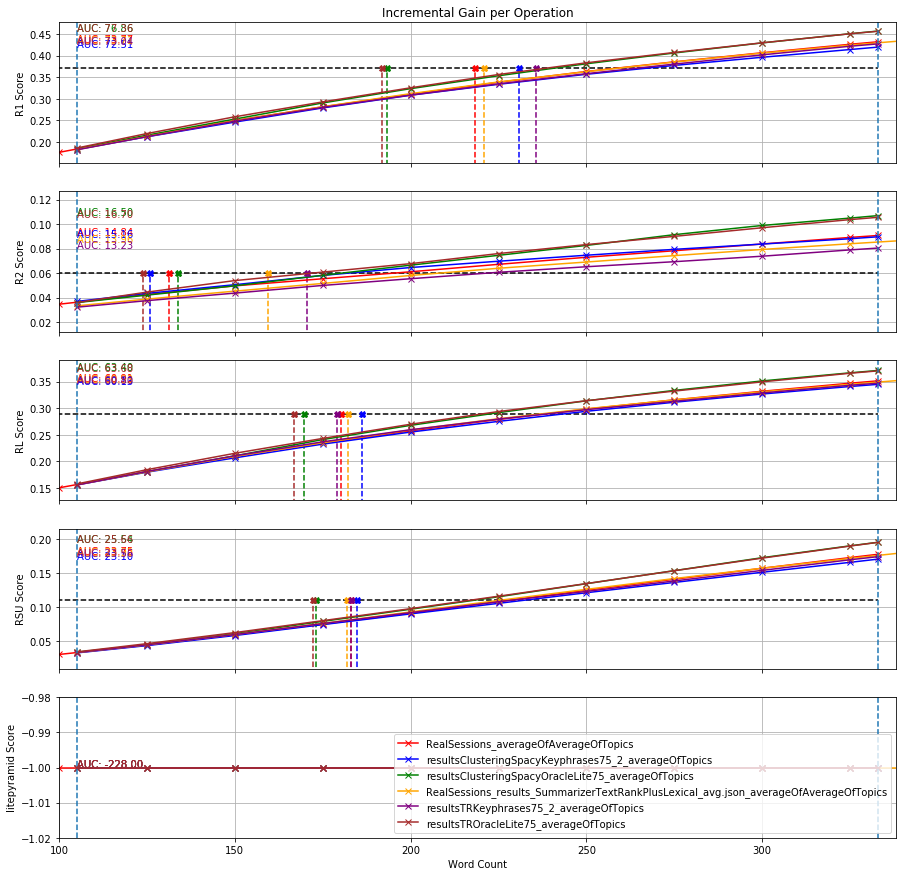

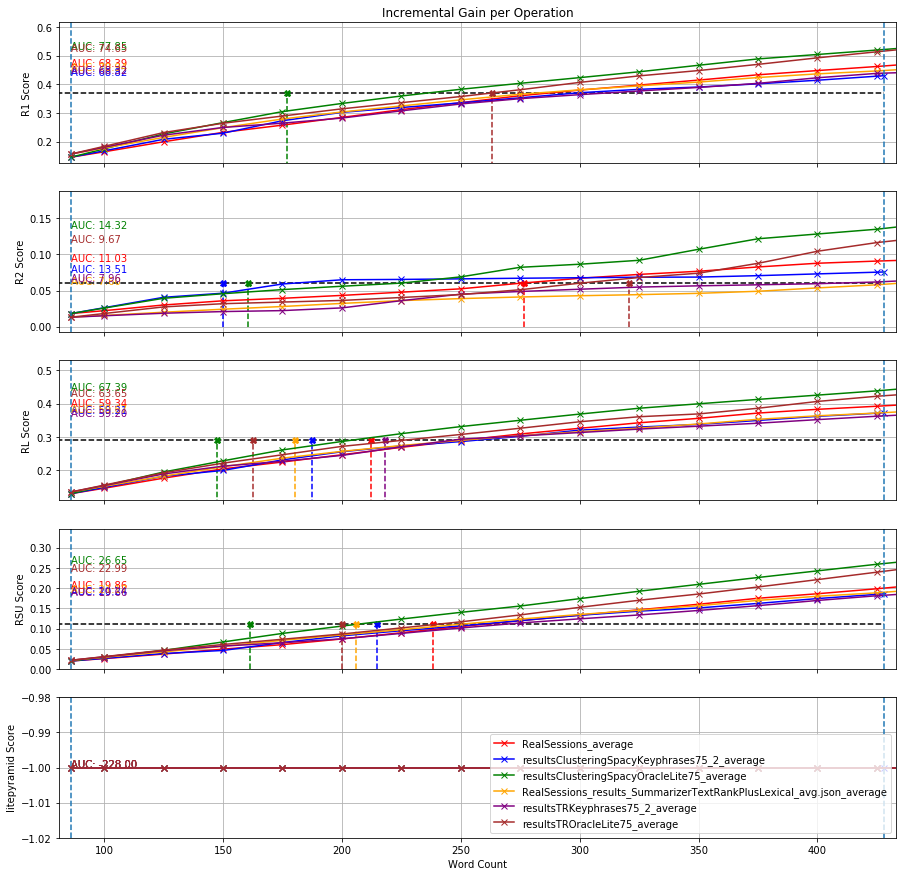

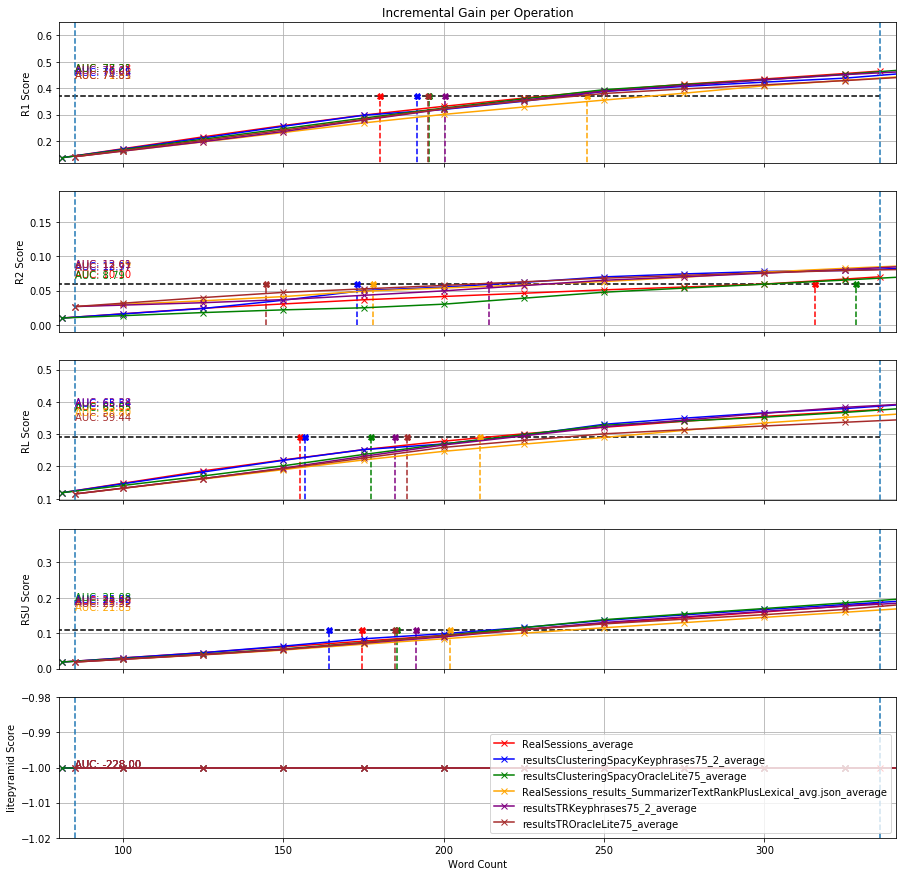

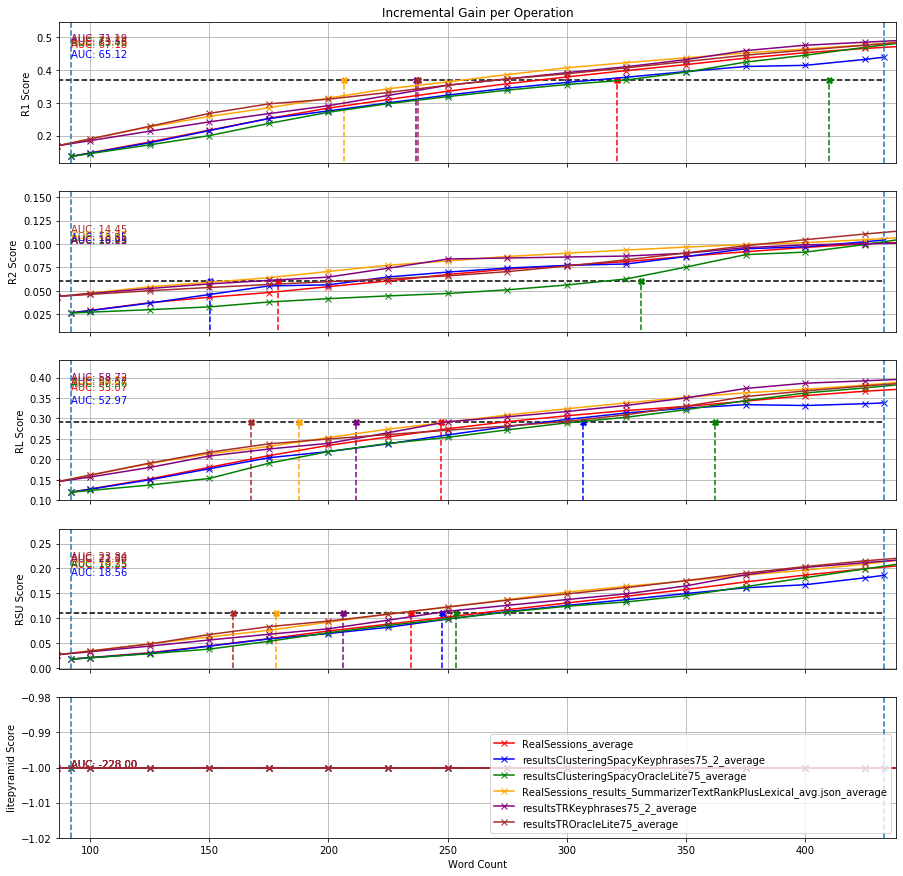

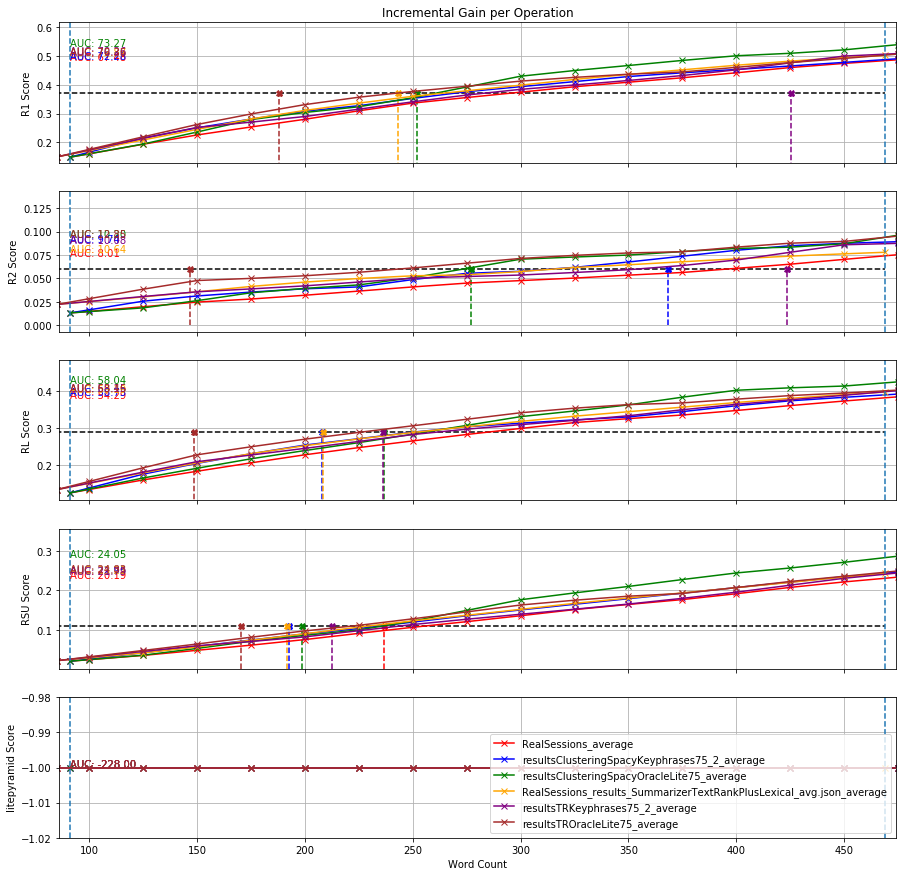

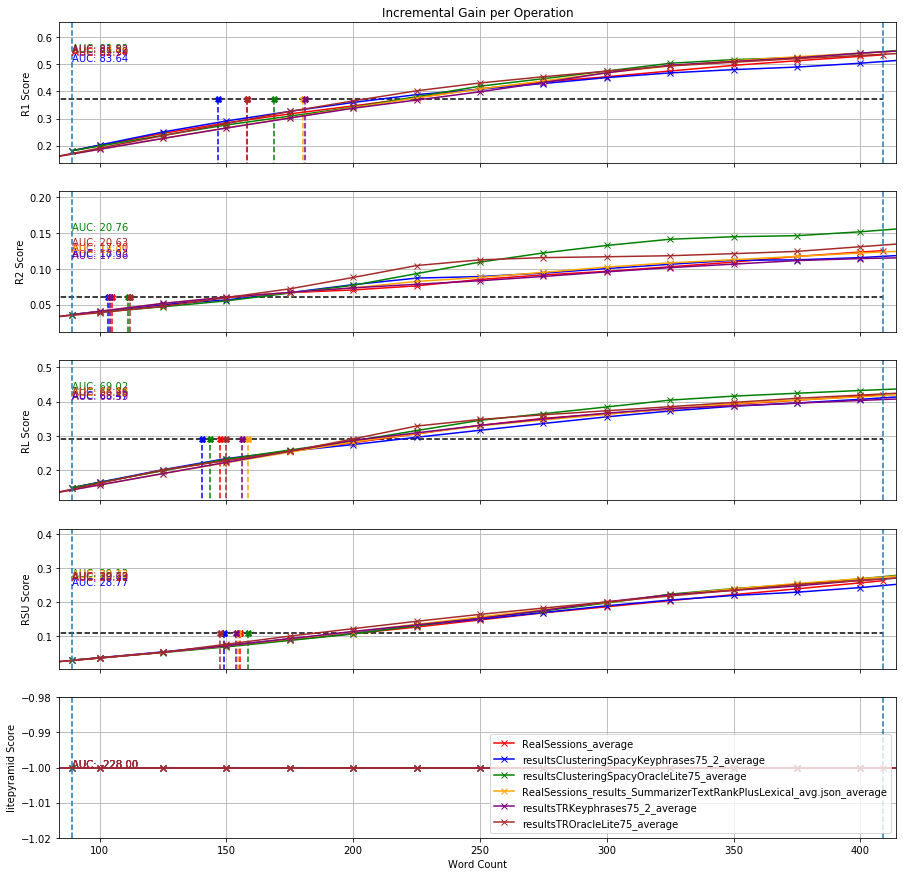

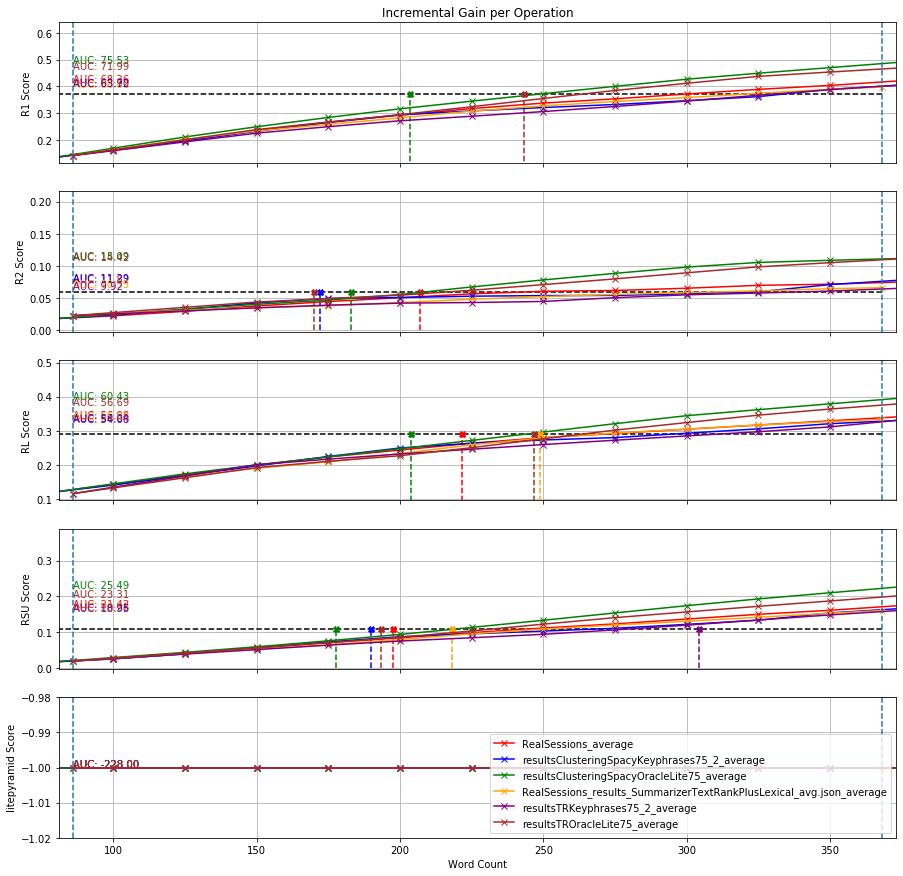

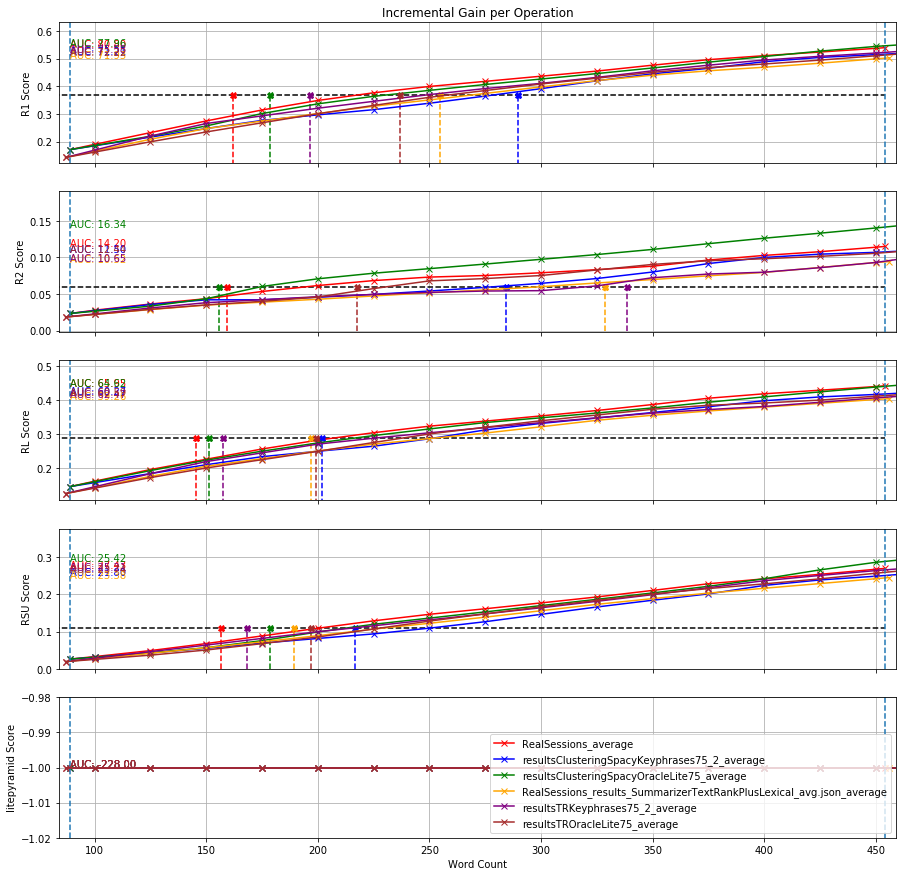

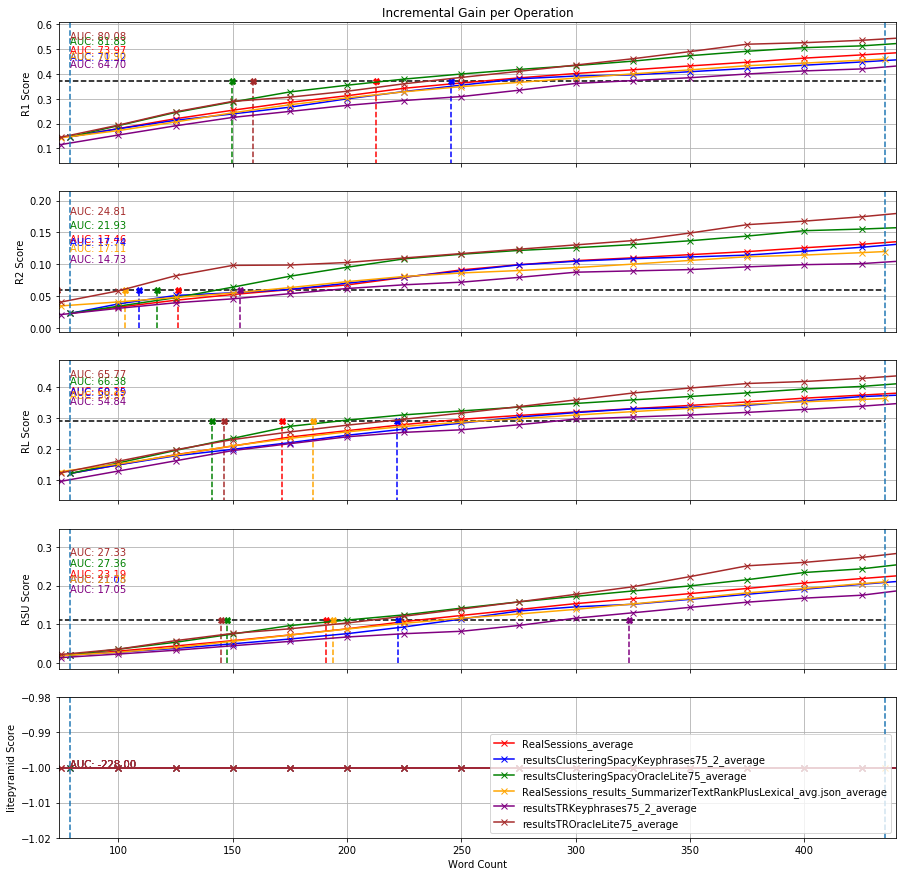

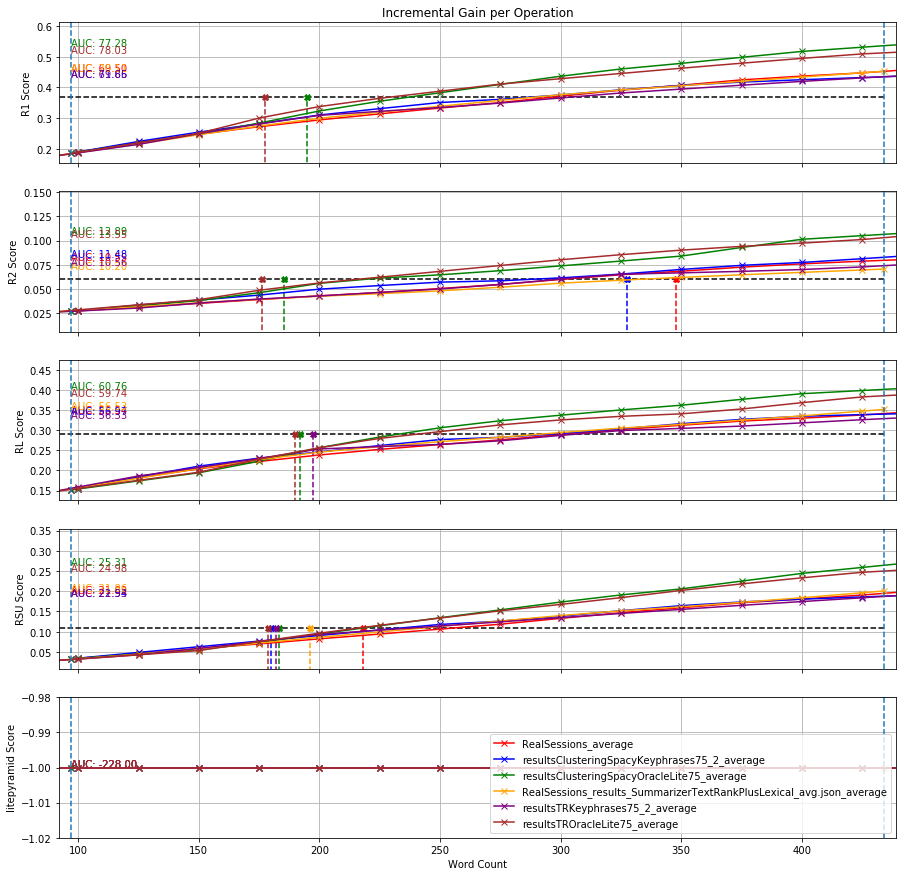

In [28]:
XMIN_AUC = 105 # float('inf')
XMAX_AUC = 333 # float('-inf')

inputFiles = [
    '../MechanicalTurk/RealSessions/results_SummarizerClustering_avg.json',
    'simulations/fromServer/resultsClusteringSpacyKeyphrases75_2/results_avg.json',
    'simulations/fromServer/resultsClusteringSpacyOracleLite75/results_avg.json',
    '../MechanicalTurk/RealSessions/results_SummarizerTextRankPlusLexical_avg.json',
    'simulations/fromServer/resultsTRKeyphrases75_2/results_avg.json',
    'simulations/fromServer/resultsTROracleLite75/results_avg.json',
]

outputFolder = '../MechanicalTurk/RealSessions/comparisonAll'

compareResults(inputFiles, outputFolder)

In [97]:
inputFiles = [
    '../MechanicalTurk/results/batch3456/results_avg.json', #results_avgOfAverages.json',
    '../MechanicalTurk/RealSessions/results_SummarizerClustering_avg.json'
]

outputFolder = '../MechanicalTurk/RealSessions/comparisonWildVsControlled'

compareResults(inputFiles, outputFolder)

NameError: name 'x' is not defined